In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astropy.modeling import models, fitting
from astroquery.nist import Nist # atomic lines
from astroquery.linelists.cdms import CDMS # molecular lines?

from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum

from scipy.integrate import trapz
from scipy.optimize import curve_fit
from scipy.signal import medfilt

from astropy.io import ascii
from astropy.io import fits


%matplotlib inline

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

# Things that should only have to be defined once, here at the top
---

In [3]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x,ampl,center,std,b):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x - center)/std)**2)) + b

In [4]:
standard_list = pd.read_csv('./standard_list.txt')
wavelen, flux,snr = ig.get_fitsdata(standard_list['Source'][0])

In [5]:
# Reduced data in txt files
# Desktop path
data_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged"

# Laptop Path
# data_path = "C:/Users/Savio/Documents/GitHub/IGRINS-Spectra/IGRINS_Merged/"
# File path for figures to live in
# Desktop path
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Laptop Path
# fig_path = "C:/Users/Savio/Documents/GitHub/IGRINS-Spectra/IGRINS_figs/standards_spectra/"


# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"/merged_standards/m*.fits")

In [6]:
merged_standard_files

['A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mAnon1_20181120_K_0075_spec_A0v.fits',
 'A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mDKTau_20181119_K_0053_spec_A0v.fits',
 'A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mHaro6-13_20190123_K_0083_spec_A0v.fits',
 'A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mHBC359_20181120_K_0063_spec_A0v.fits',
 'A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mHBC427_20171229_K_0064_spec_A0v.fits',
 'A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mHD286178_20190120_K_0049_spec_A0v.fits',
 'A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mHQTau_20190119_K_0031_spec_A0v.fits',
 'A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mHubble4_20181120_K_0083_spec_A0v.fits',
 'A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged/merged_standards\\mJH108_20171

In [26]:
# Determine the maximum length of flux arrays
max_flux_length = max(len(fits.getdata(file)[1]) for file in merged_standard_files)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in merged_standard_files)
max_snr_length = max(len(fits.getdata(file)[2]) for file in merged_standard_files)
# Initialize flux_stack with NaN values

wavelen_stack = np.full((max_wavelen_length, len(merged_standard_files)), np.nan)
flux_stack = np.full((max_flux_length, len(merged_standard_files)), np.nan)
snr_stack = np.full((max_snr_length, len(merged_standard_files)), np.nan)

# Fill flux_stack with flux data
for i, file in enumerate(merged_standard_files):
    # Get data
    wavelen = fits.getdata(file)[0]
    flux = fits.getdata(file)[1]
    median_flux = medfilt(flux, kernel_size=51)
    norm_flux = flux/median_flux

    snr = fits.getdata(file)[2]
    # Clean data a bit
    snr_min = 10 # Minimum SNR
    snr_max = 1e4 # Maxmimum SNR
    snr_cut = (snr > snr_min) & (snr < snr_max) # bitwise SNR masking

    # flux_min = 0 # minimum flux
    # flux_cut = flux > flux_min # bitwise flux masking

    wavelen_min = 1.98
    wavelen_max = 2.48
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    wavelen = wavelen[snr_cut & wavelen_cut]
    norm_flux = norm_flux[snr_cut & wavelen_cut]
    flux_stack[:len(norm_flux),i] = norm_flux
    wavelen_stack[:len(wavelen),i] = wavelen
    # flux_stack[:len(flux), i] = flux

C:\Users\Savio\AppData\Local\Temp\ipykernel_14920\339461821.py:17: RuntimeWarning: divide by zero encountered in divide
  norm_flux = flux/median_flux


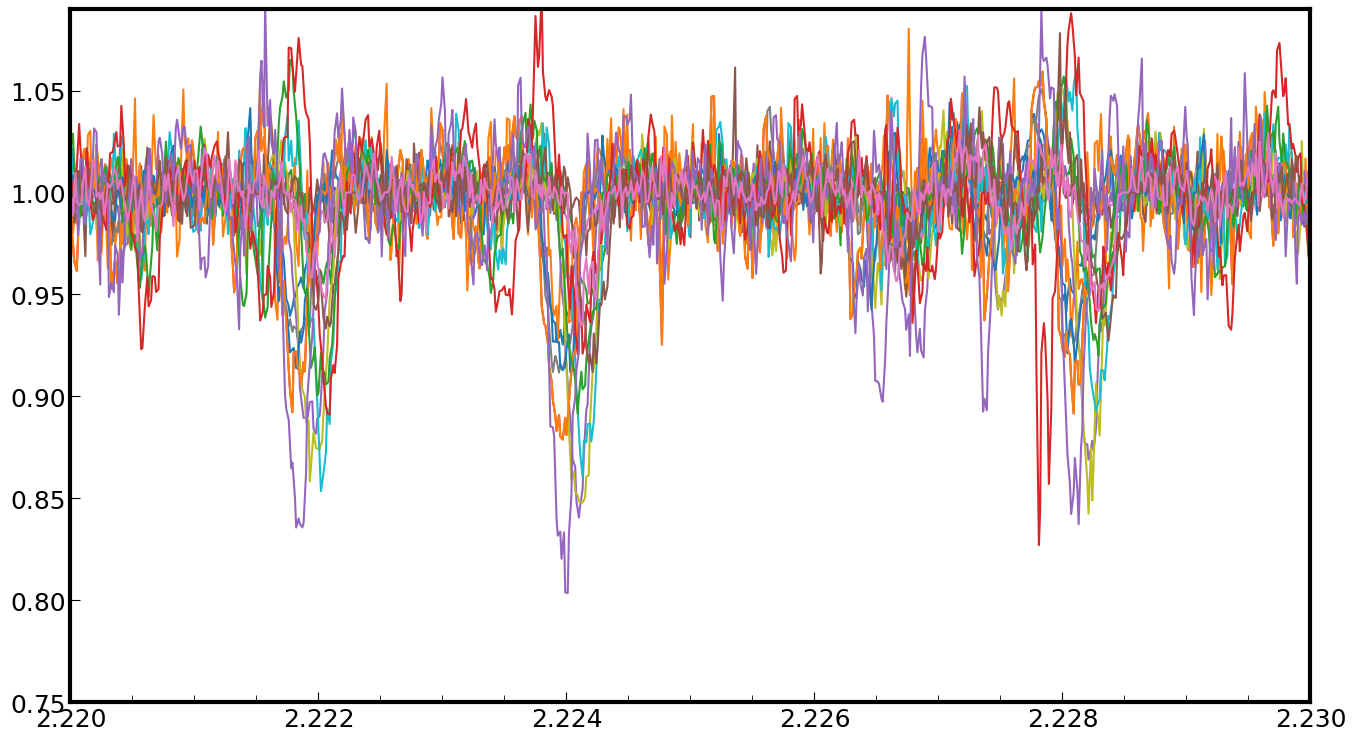

In [38]:
fig = plt.subplots(figsize=(16,9))
for i in range(len(standard_list)):
    plt.plot(wavelen_stack[:,i],flux_stack[:,i])
    plt.xlim(2.22,2.23)
    plt.ylim(0.75,1.09)

In [9]:
# # Cell takes ~30 seconds to run
# cont_fit_stack = np.zeros((len(flux_stack[:,0]),len(merged_standard_files)))
# for standard in range(len(merged_standard_files)):
#     # Assuming ig.get_fitsdata returns wavelen, flux, snr
#     # mask = (wavelen_stack[:,standard] >= start) & (wavelen_stack[:,standard] < end)
#     # Normalize flux
#     norm_flux = ig.normalize_flux(flux_stack[:,standard])

#     # Fit continuum
#     spec = Spectrum1D(flux=flux_stack[:,standard]*u.ct, spectral_axis=wavelen_stack[:,standard]*u.um)
#     with warnings.catch_warnings():  # Ignore warnings
#         warnings.simplefilter('ignore')    
#         flux_fit = fit_generic_continuum(spec)
#     cont_fit_stack[:,standard] = flux_fit(wavelen_stack[:,standard]*u.um)

In [10]:
# spec_step = 0.005
# test = np.arange(1.98, 2.48, spec_step)  # arange to step through the spectrum in spec_step micron increments
# flux_const = np.linspace(-3,5,len(merged_standard_files))

# cont_fit_stack = np.zeros((len(flux_stack[:,0]),len(merged_standard_files)))
# for start in test:
#     # fig, ax = plt.subplots(figsize=(16, 9))
#     end = start + spec_step  # Determine
    
#     for standard in range(len(merged_standard_files)):
#         # Assuming ig.get_fitsdata returns wavelen, flux, snr
#         # mask = (wavelen_stack[:,standard] >= start) & (wavelen_stack[:,standard] < end)
#         # Normalize flux
#         norm_flux = ig.normalize_flux(flux_stack[:,standard])

#         # Fit continuum
#         spec = Spectrum1D(flux=flux_stack[:,standard]*u.ct, spectral_axis=wavelen_stack[:,standard]*u.um)
#         with warnings.catch_warnings():  # Ignore warnings
#             warnings.simplefilter('ignore')    
#             flux_fit = fit_generic_continuum(spec)
#         cont_fit_stack[:,standard] = flux_fit(wavelen_stack[:,standard]*u.um)
#         # print(len(cont_fit_stack))
#         # Plot spectrum and continuum fit
#         # ax.plot(wavelen_stack[:,i][mask], norm_flux[mask]+flux_const[standard], '-.', c='black',zorder=100)#, label='Spectrum {}'.format(standard))

#     # ax.set_title(f'{start:.4f}-{end:.4f} ') # make title
#     # ax.set_xlim(start,end) # set xlim based on start and end wavelength values
#     # ax.set_ylim(-0.5,3.5) #

In [11]:
# fig = plt.figure(figsize=(16,9))
# # Iterate over each spectrum
# for i in range(len(merged_standard_files)):
#     # Assuming ig.get_fitsdata returns wavelen, flux, snr
#     wavelen, flux, snr = ig.get_fitsdata(merged_standard_files[i])

#     # Normalize flux
#     norm_flux = ig.normalize_flux(flux)

#     # Fit continuum
#     spec = Spectrum1D(flux=flux*u.ct, spectral_axis=wavelen*u.um)
#     with warnings.catch_warnings():  # Ignore warnings
#         warnings.simplefilter('ignore')    
#         flux_fit = fit_generic_continuum(spec)
#     cont_fit = flux_fit(wavelen*u.um)

#     # Plot spectrum and continuum fit
#     plt.plot(wavelen, flux, '-', mec='black', label='Spectrum {}'.format(i))
#     plt.plot(wavelen, cont_fit, '-', mec='orange', label='Continuum Fit {}'.format(i))

# # Add labels and title
# plt.xlabel('Wavelength ($\mu m$)')
# plt.ylabel('Flux (ct)')
# plt.title('Spectra and Continuum Fits')

# # Add legend
# # plt.legend()

# # Adjust layout and display plot
# plt.tight_layout()
# plt.show()

In [12]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.0*u.um,2.48*u.um,
                        linename = 'Na I, Sc I, Si I, Fe I,Fe II, Al I, Mg I, Ca I, H I, Ti I',
                        energy_level_unit='eV',output_order='wavelength')
igrins_wav_cut = (lines_table['Observed'] > 1.92) & (lines_table['Observed'] < 2.48)

lines_table = lines_table[igrins_wav_cut]

na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'red']

# lines_table[fe1_mask] # check where some lines are

In [15]:

medfilt(flux)

array([46364.19921875, 47847.80078125, 49299.69921875, ...,
       28152.19921875, 28152.19921875, 26987.59960938])

C:\Users\Savio\AppData\Local\Temp\ipykernel_14920\3907061183.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(16, 9))


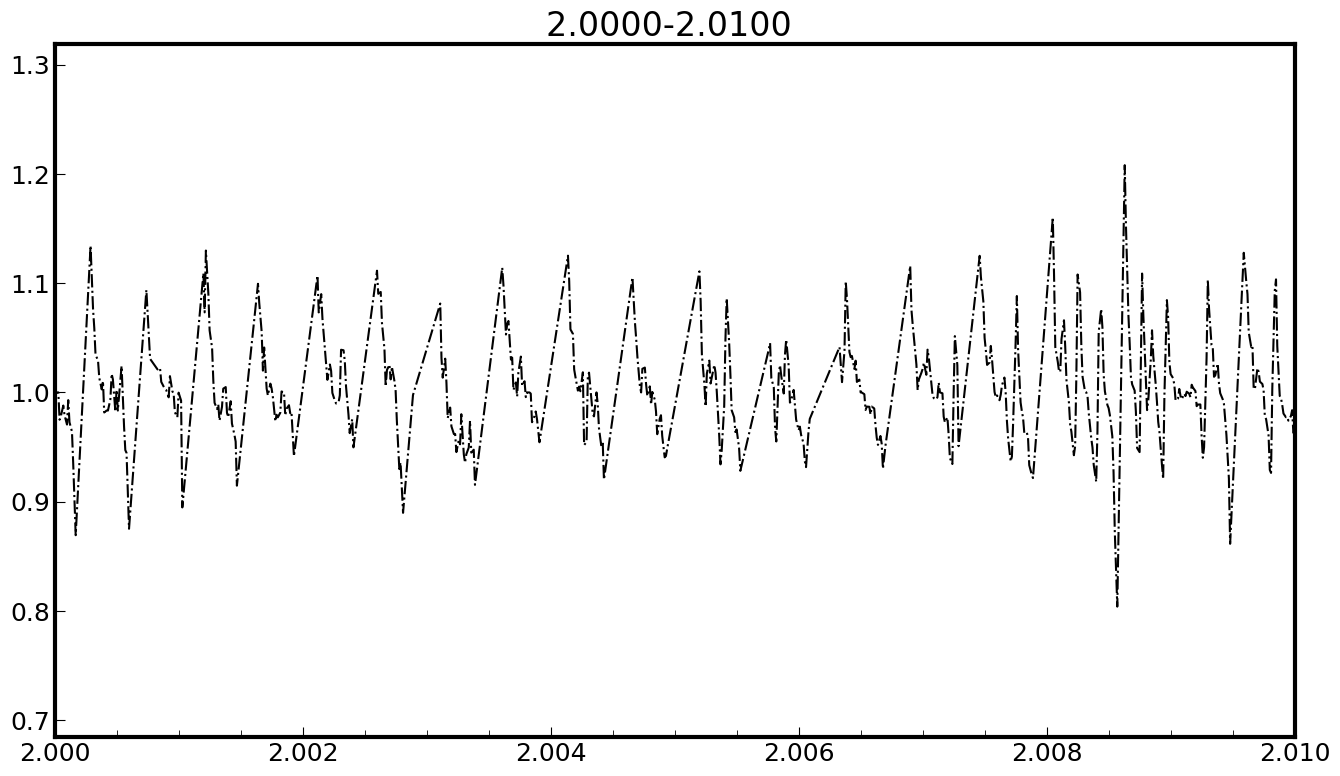

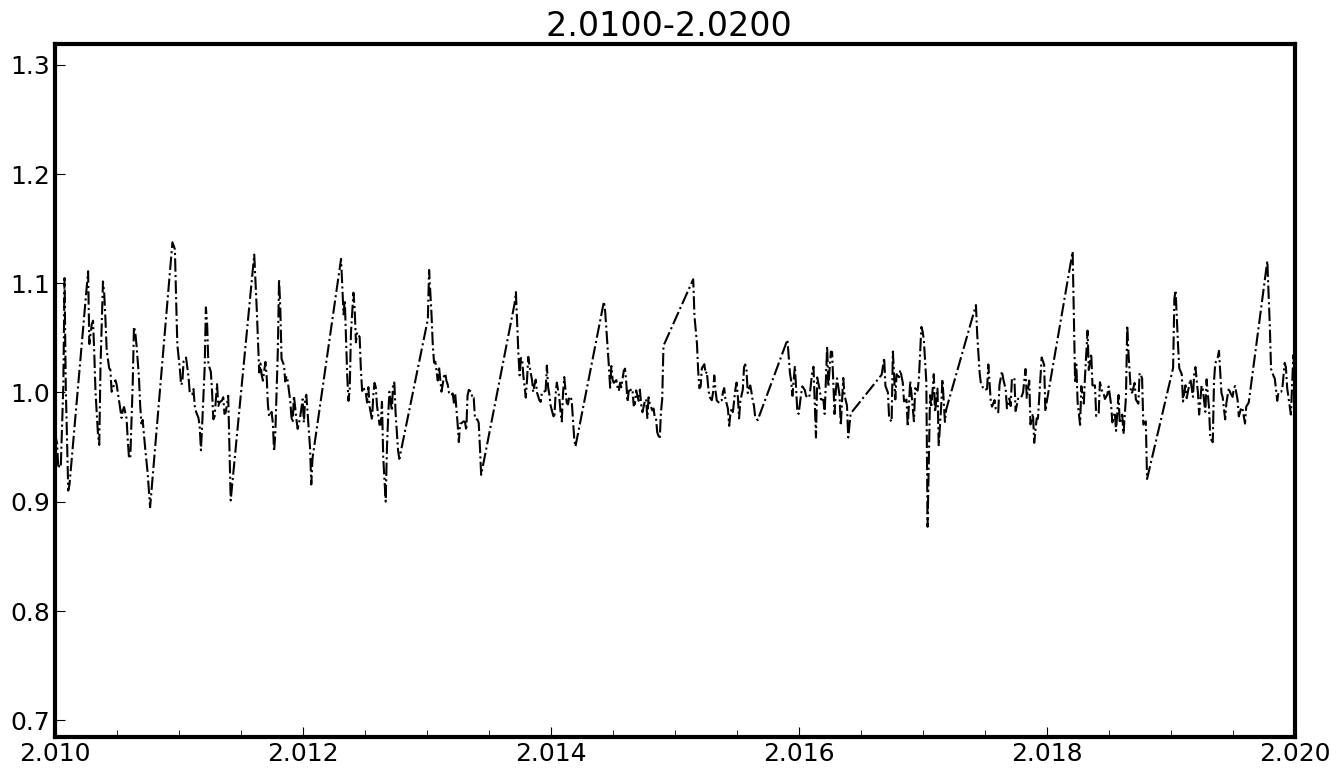

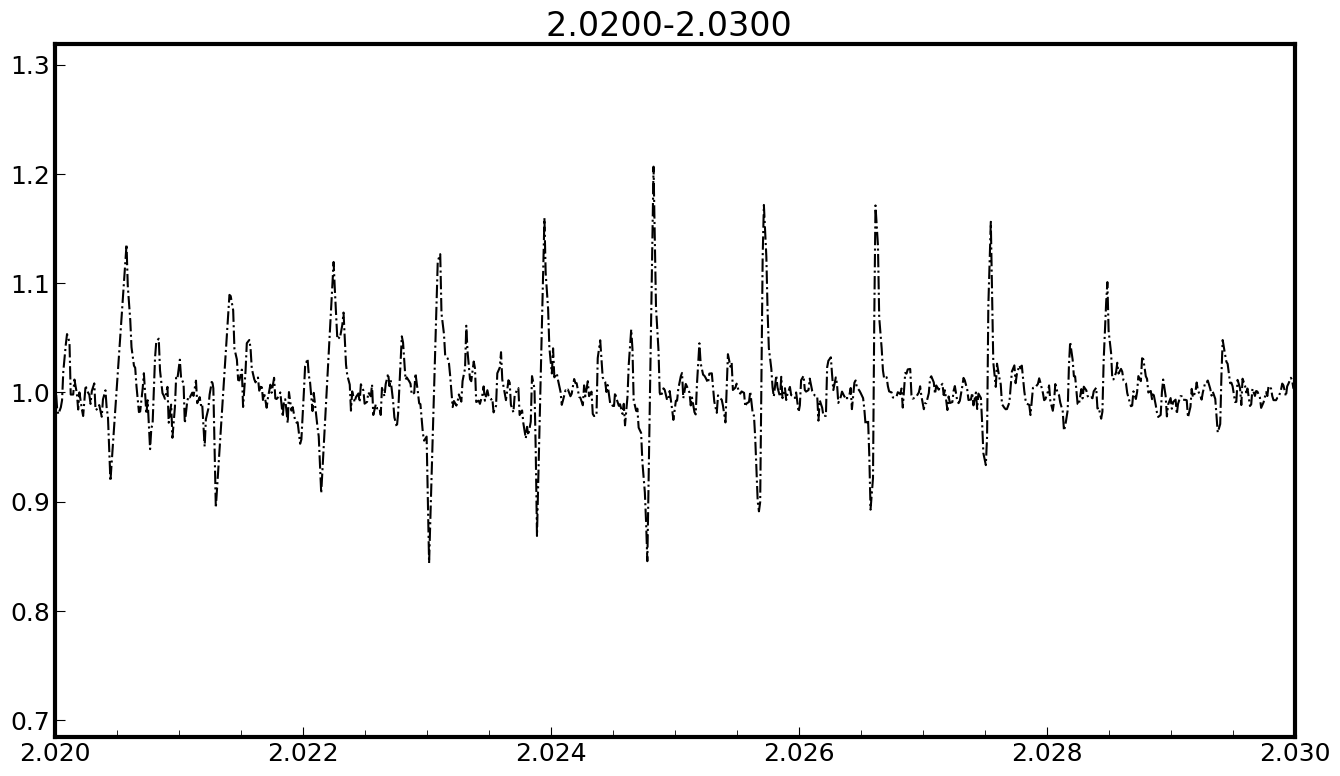

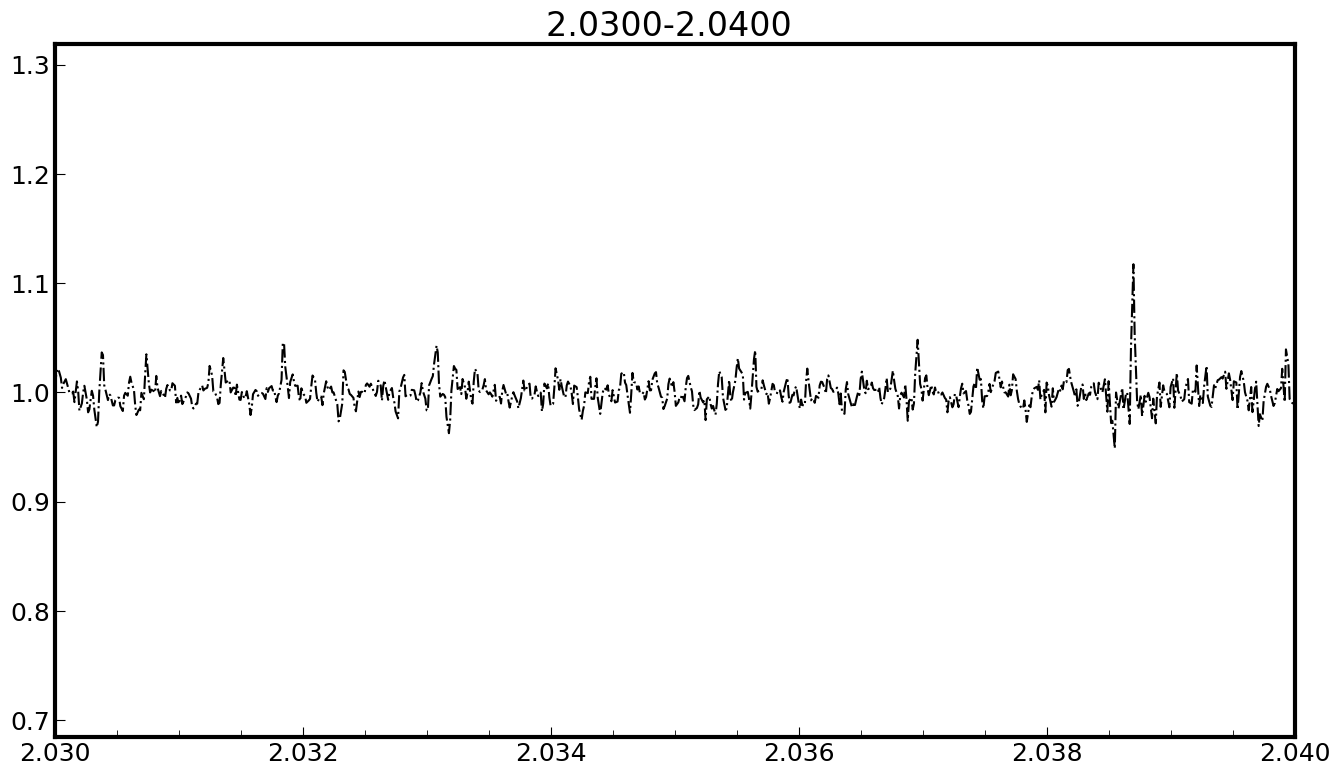

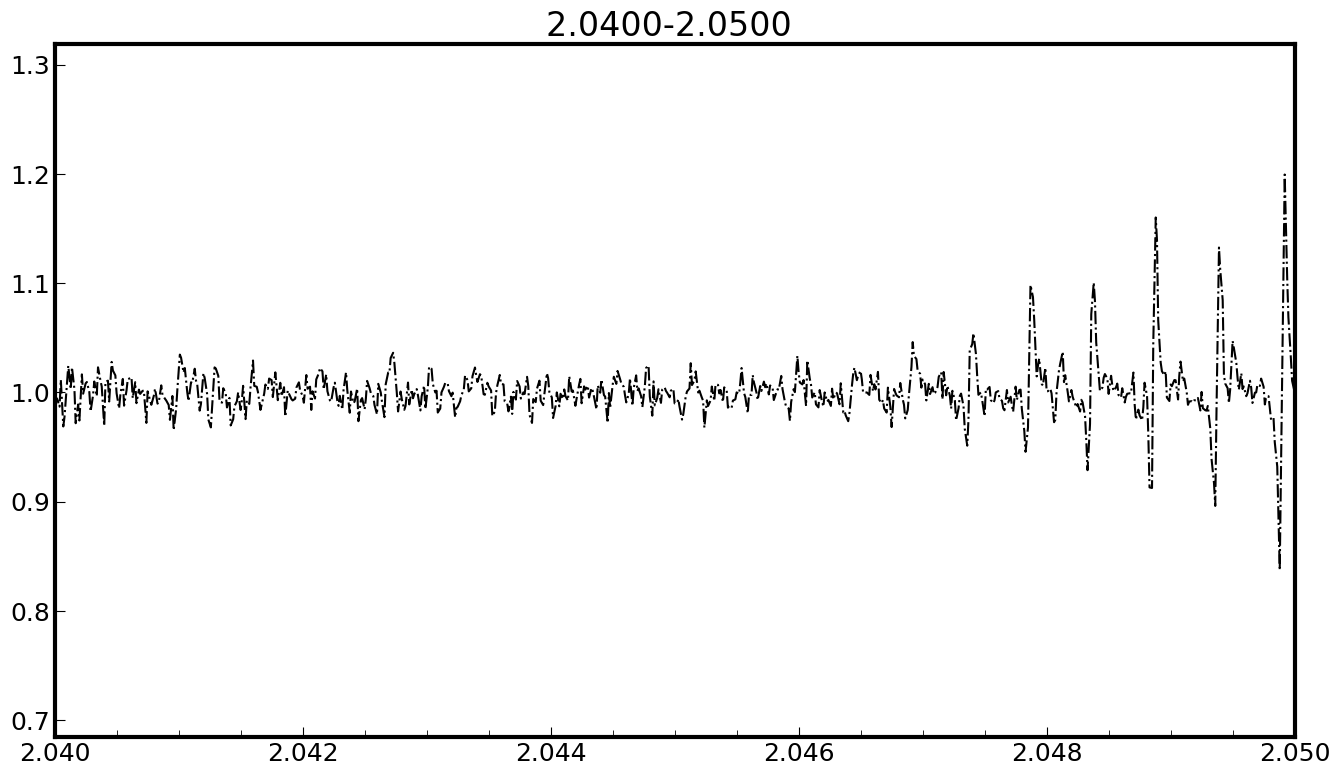

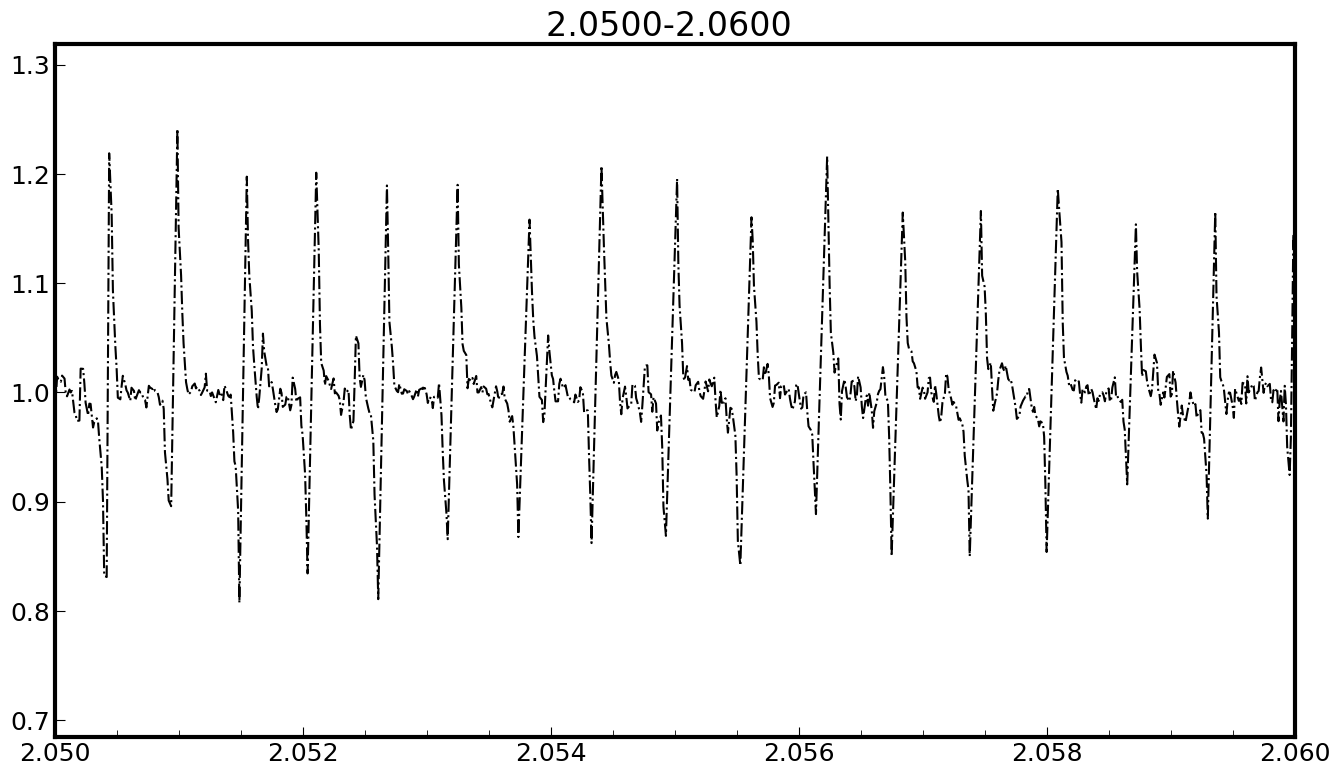

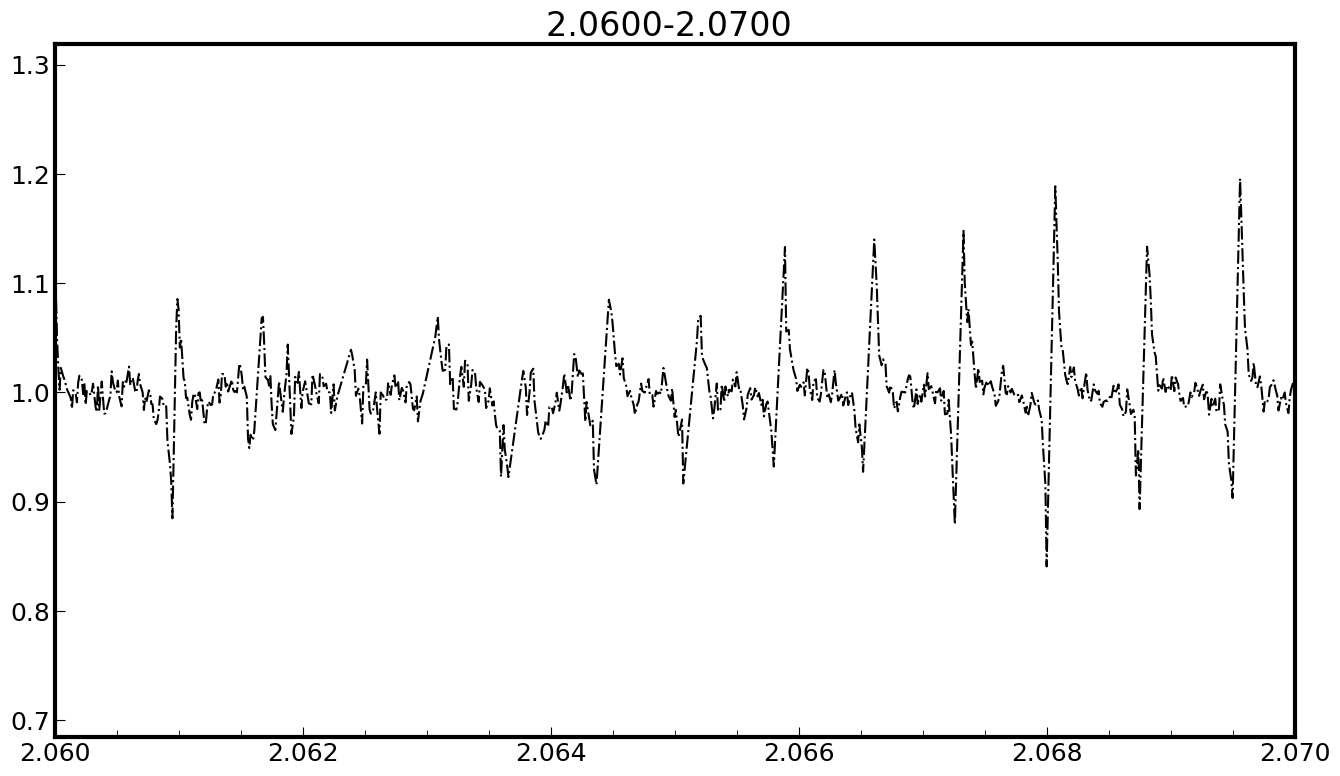

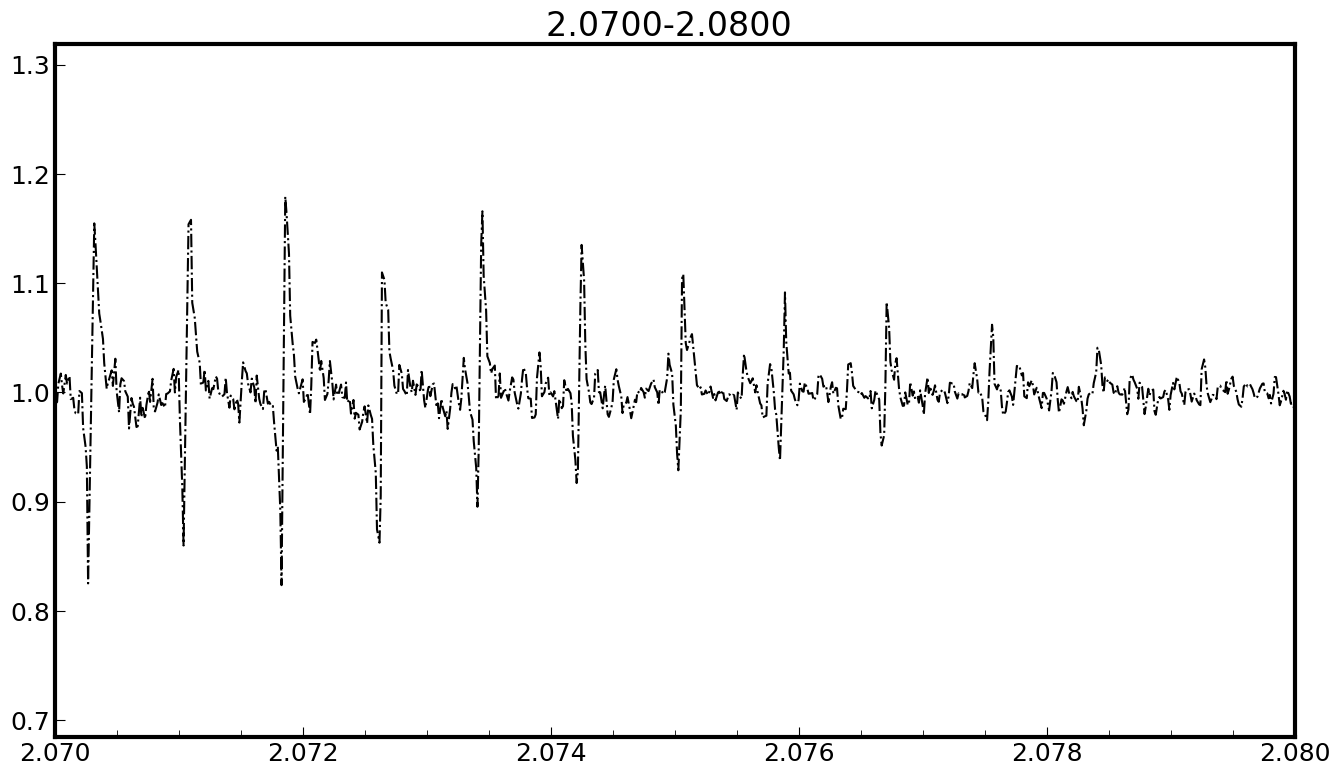

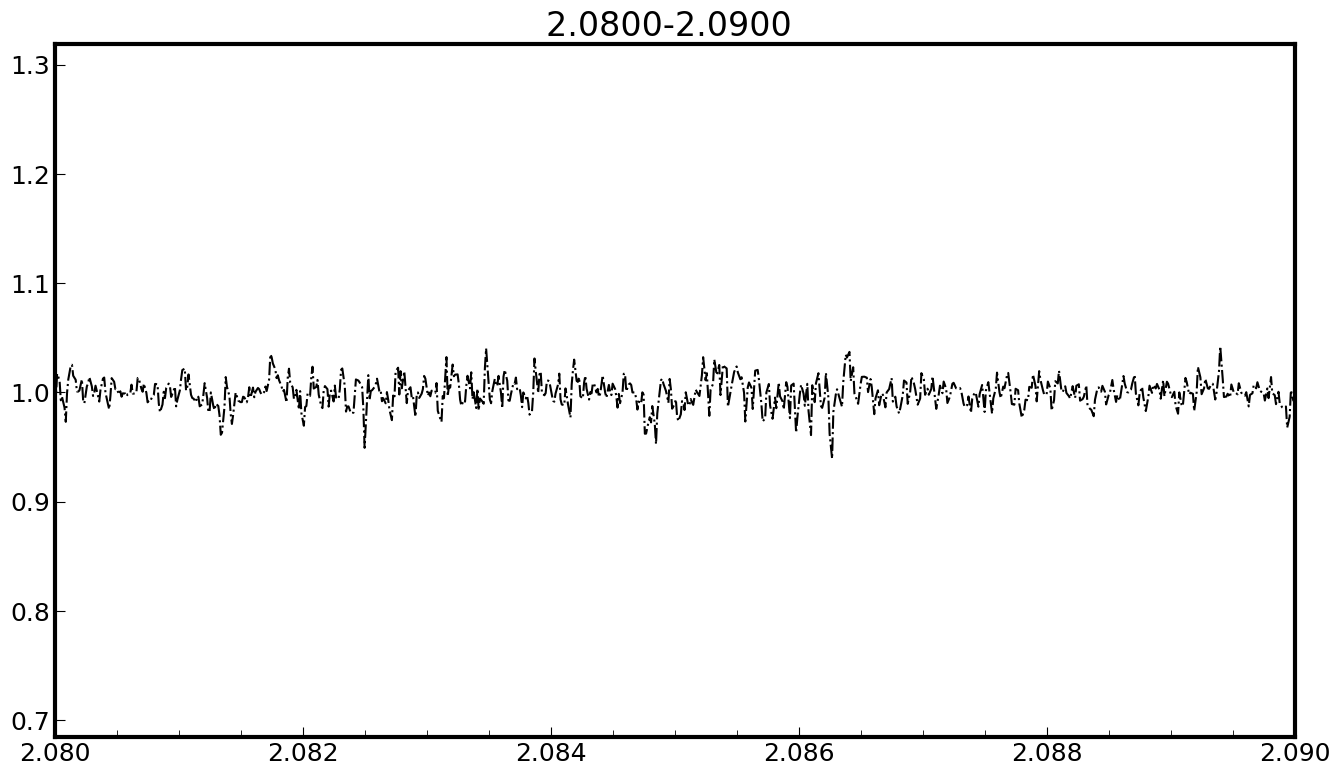

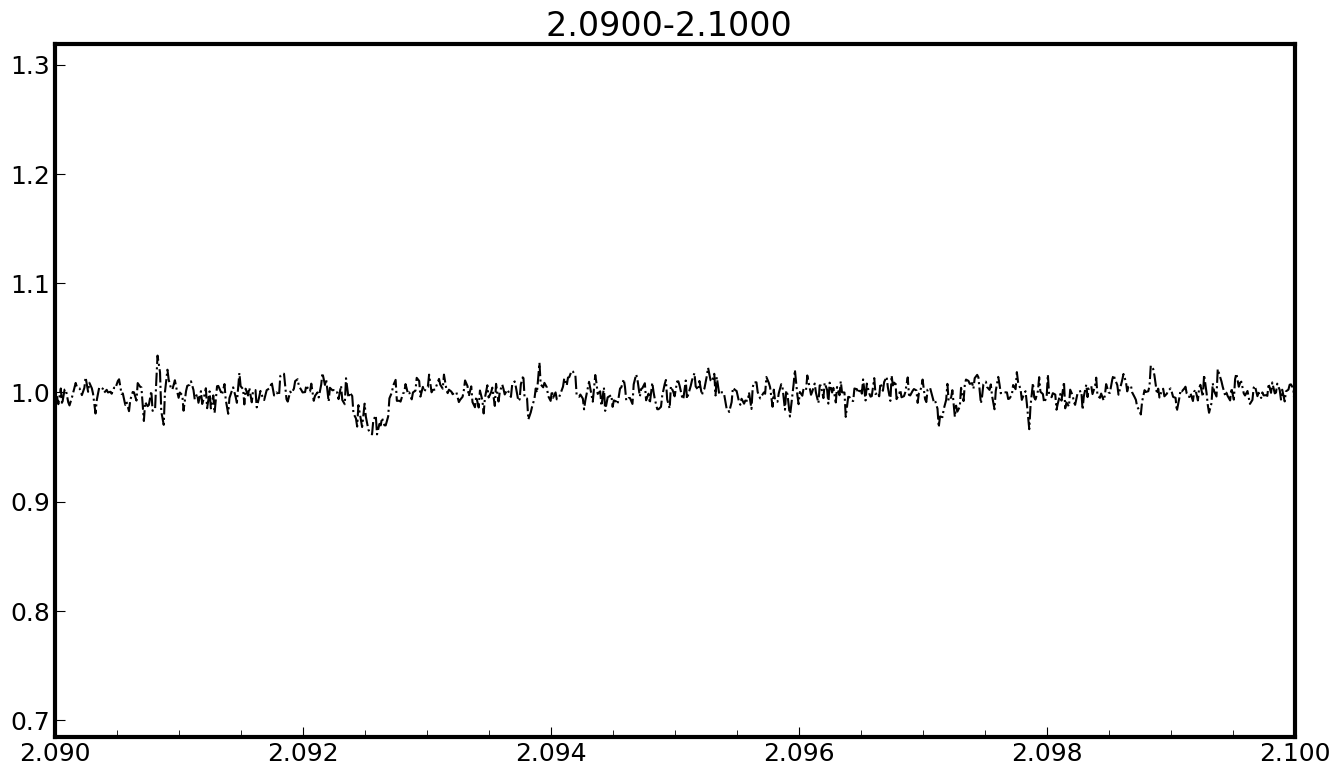

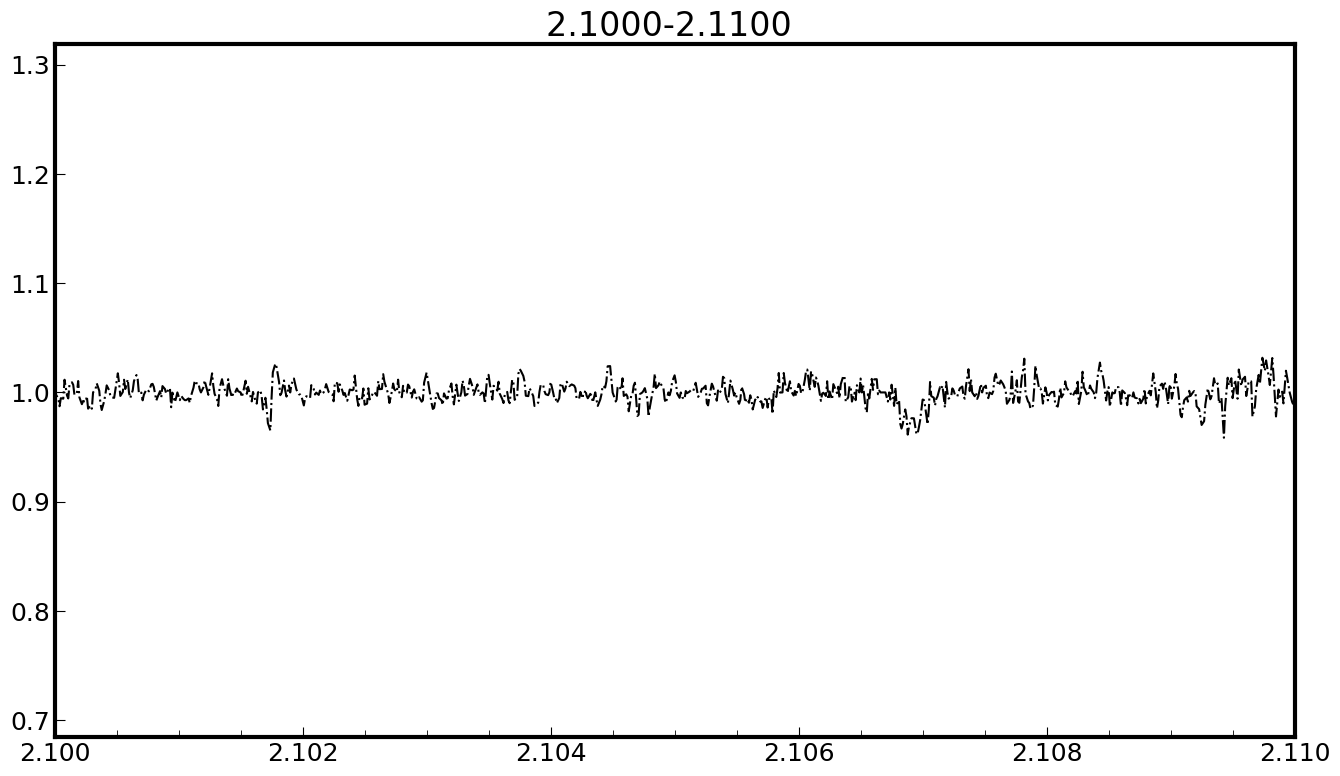

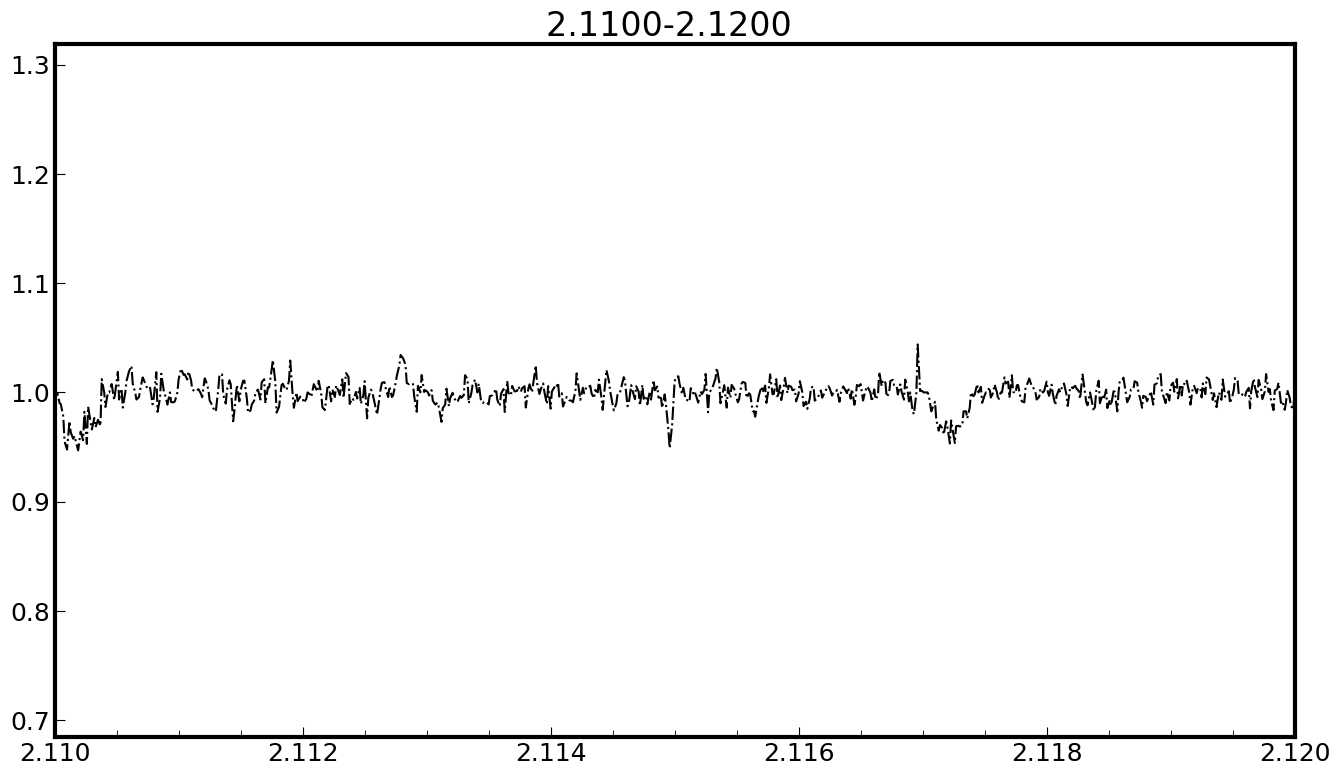

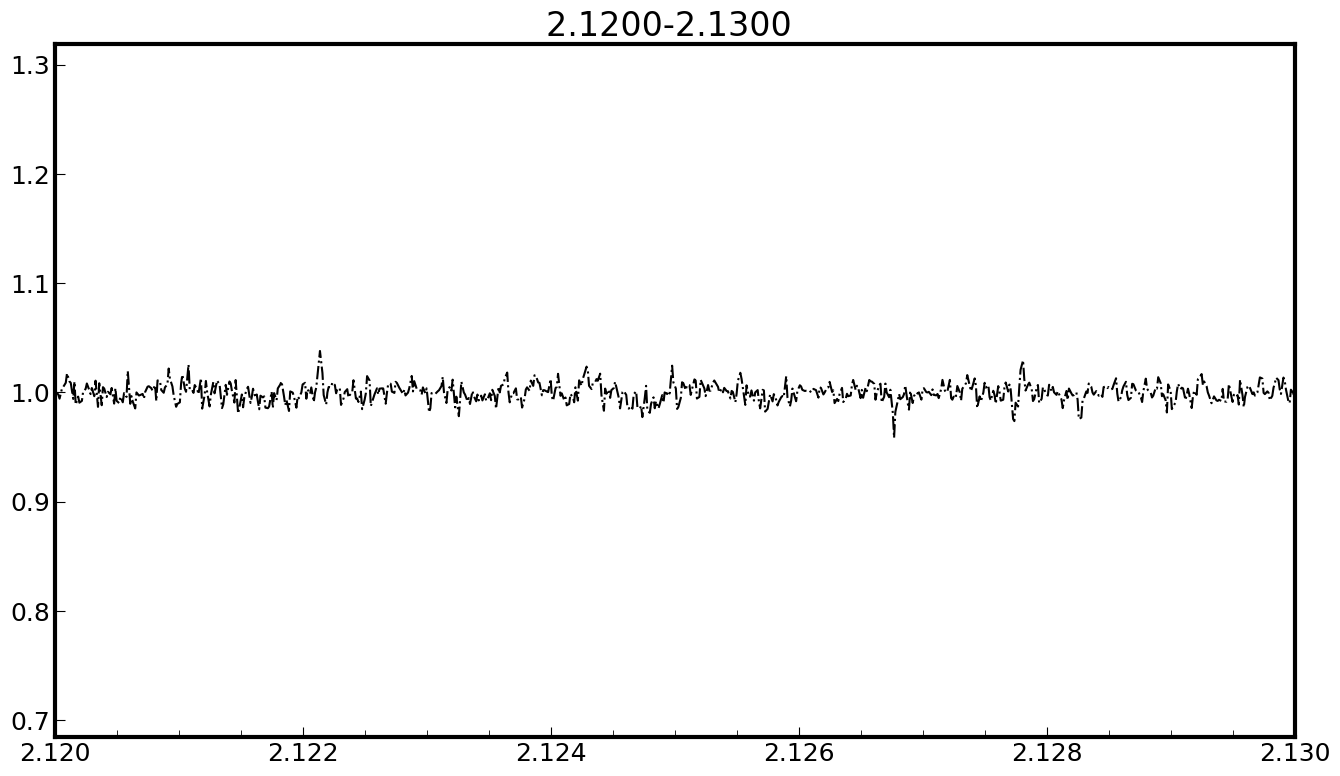

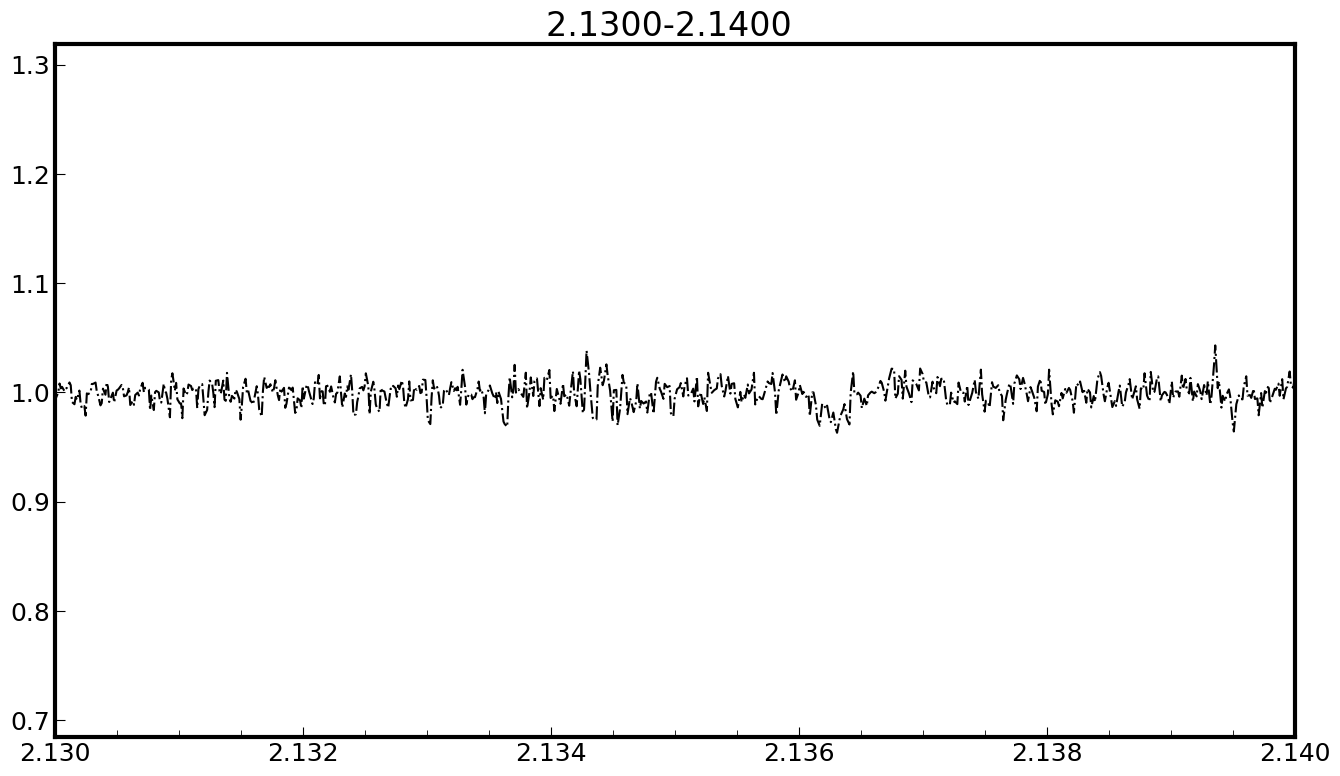

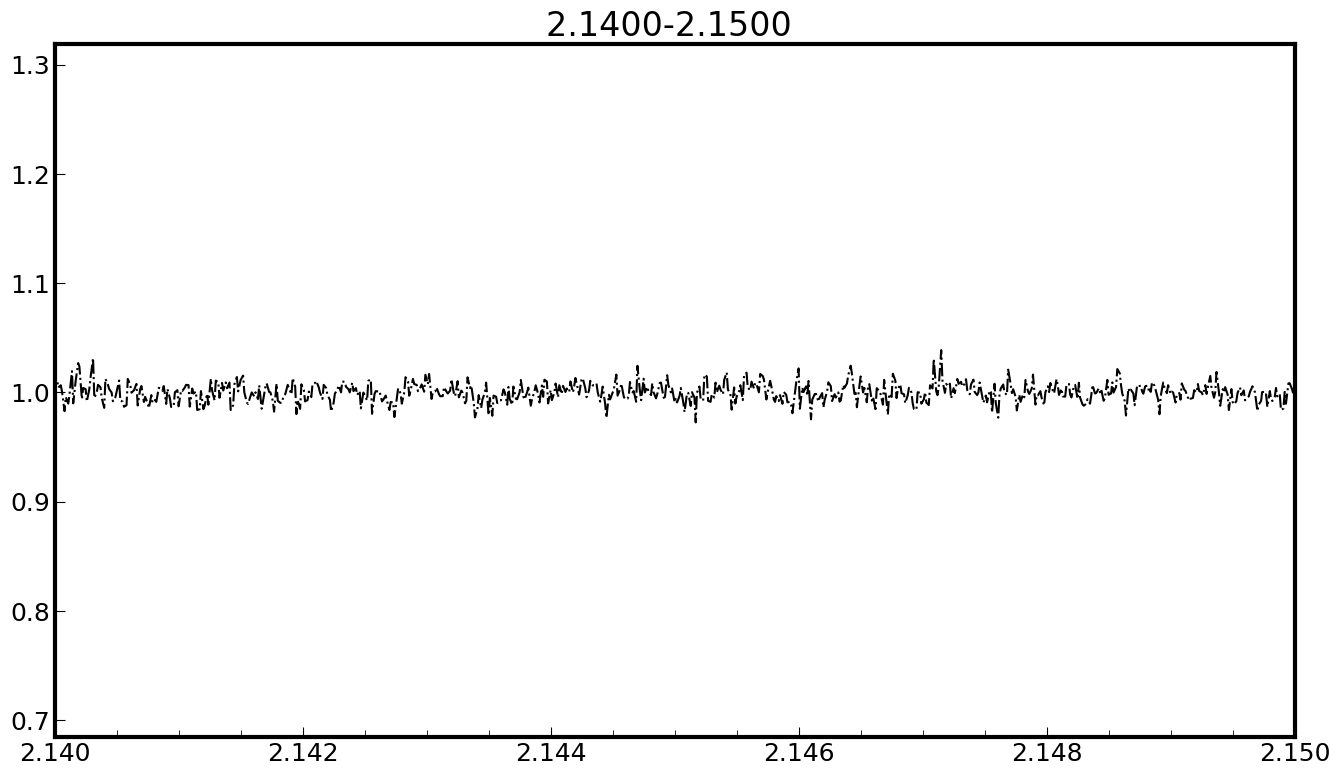

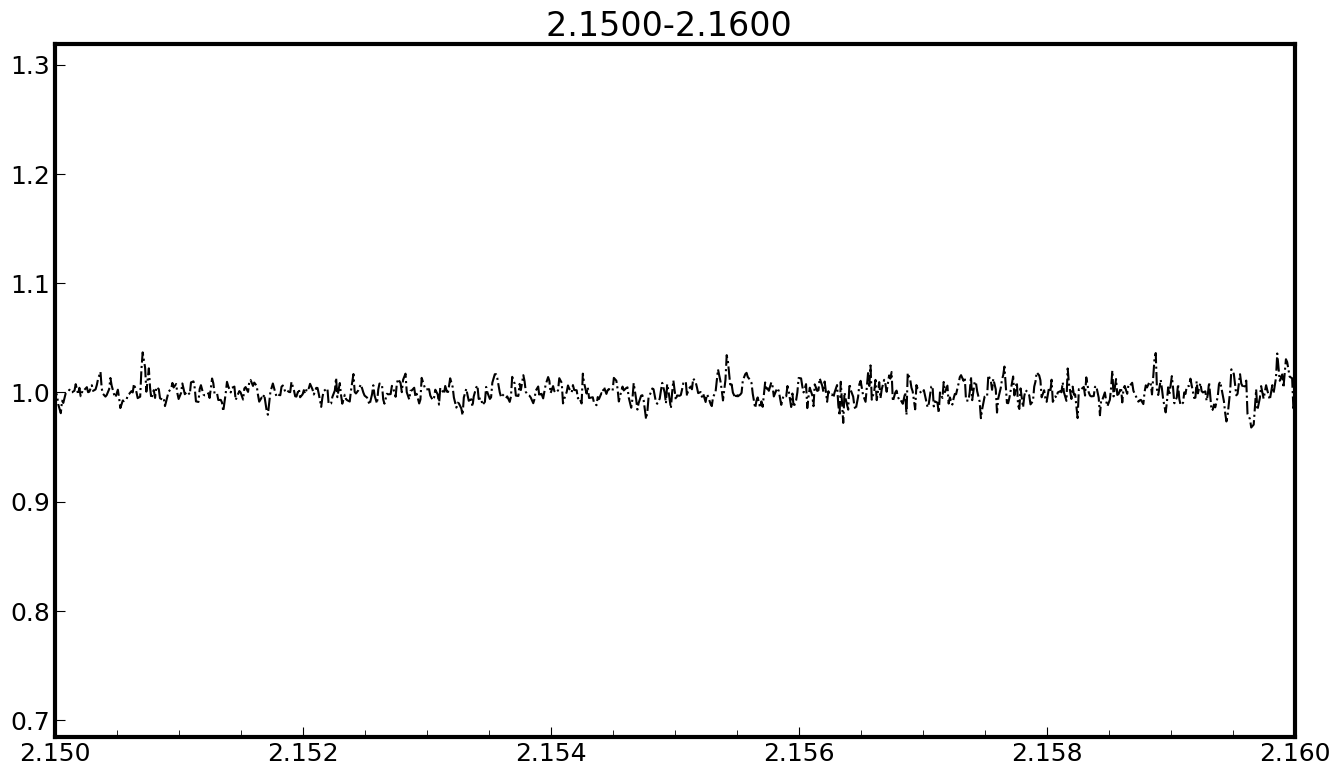

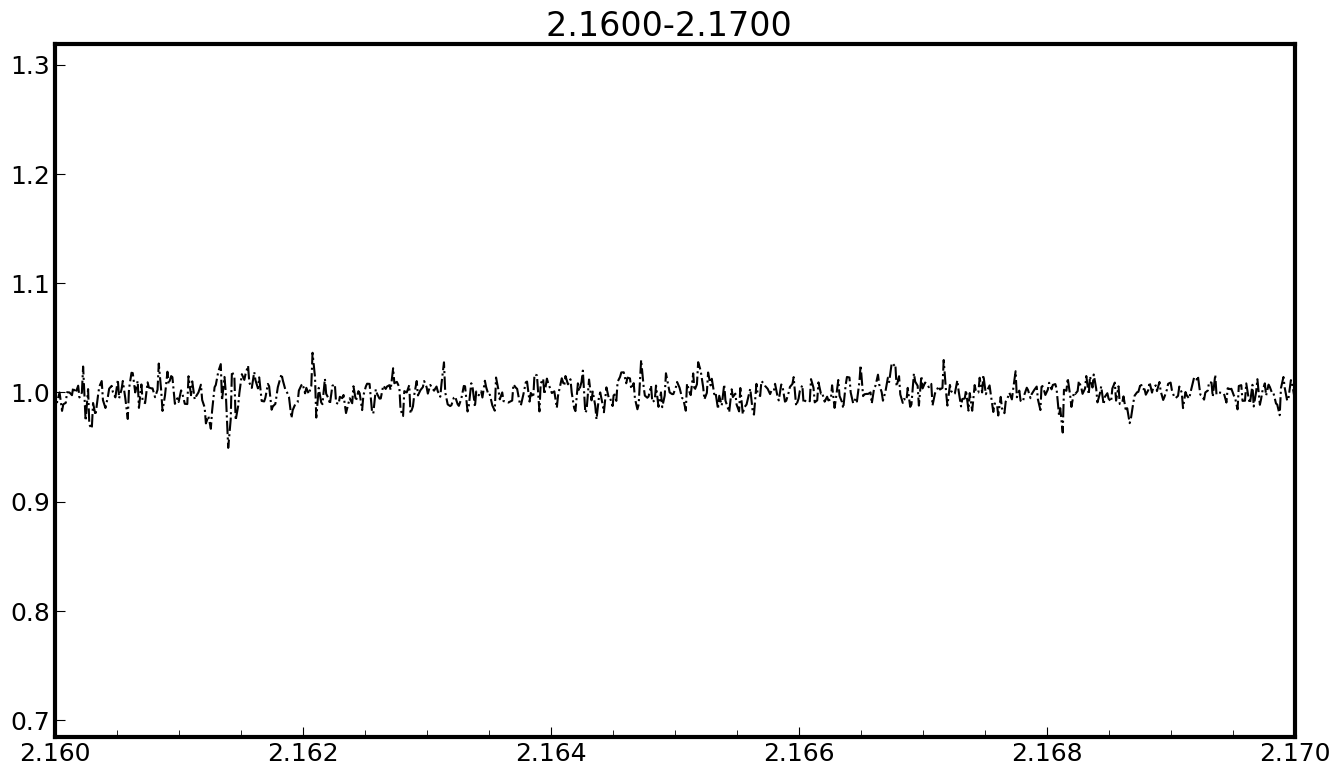

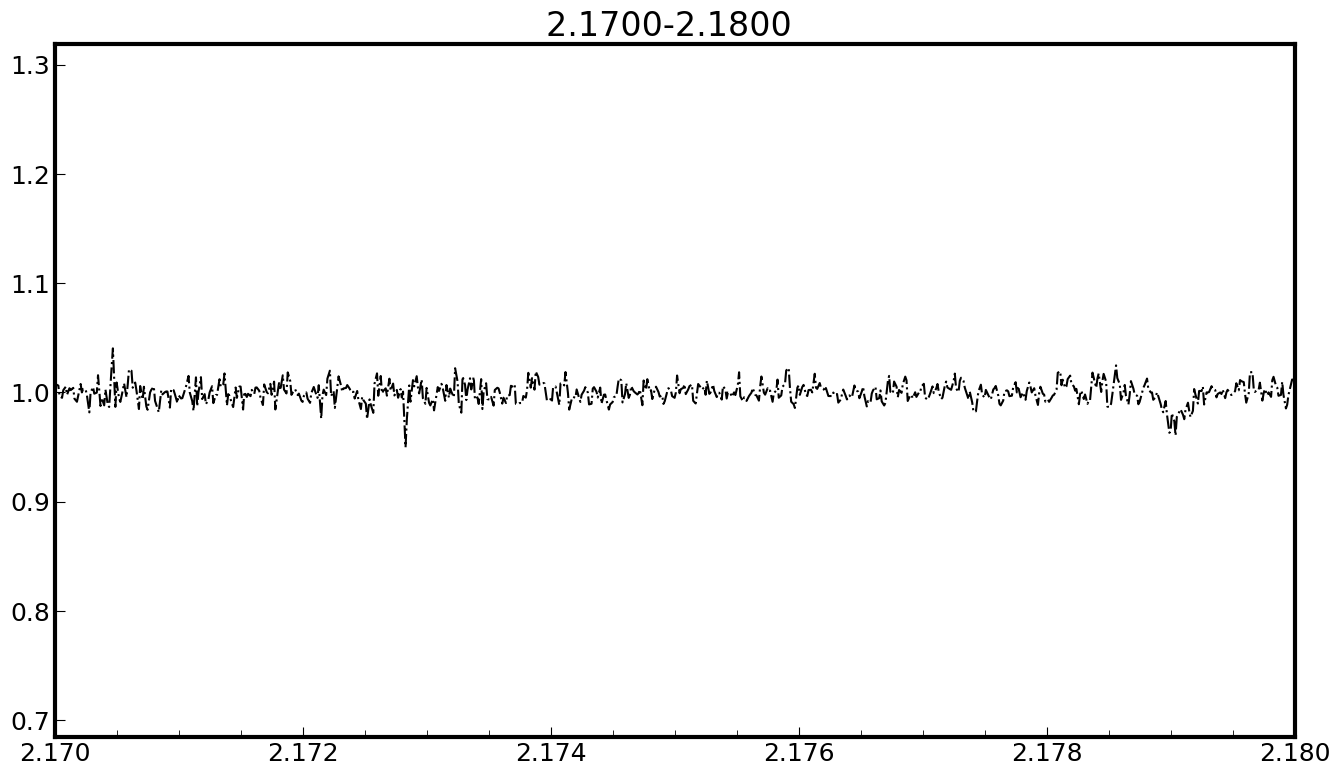

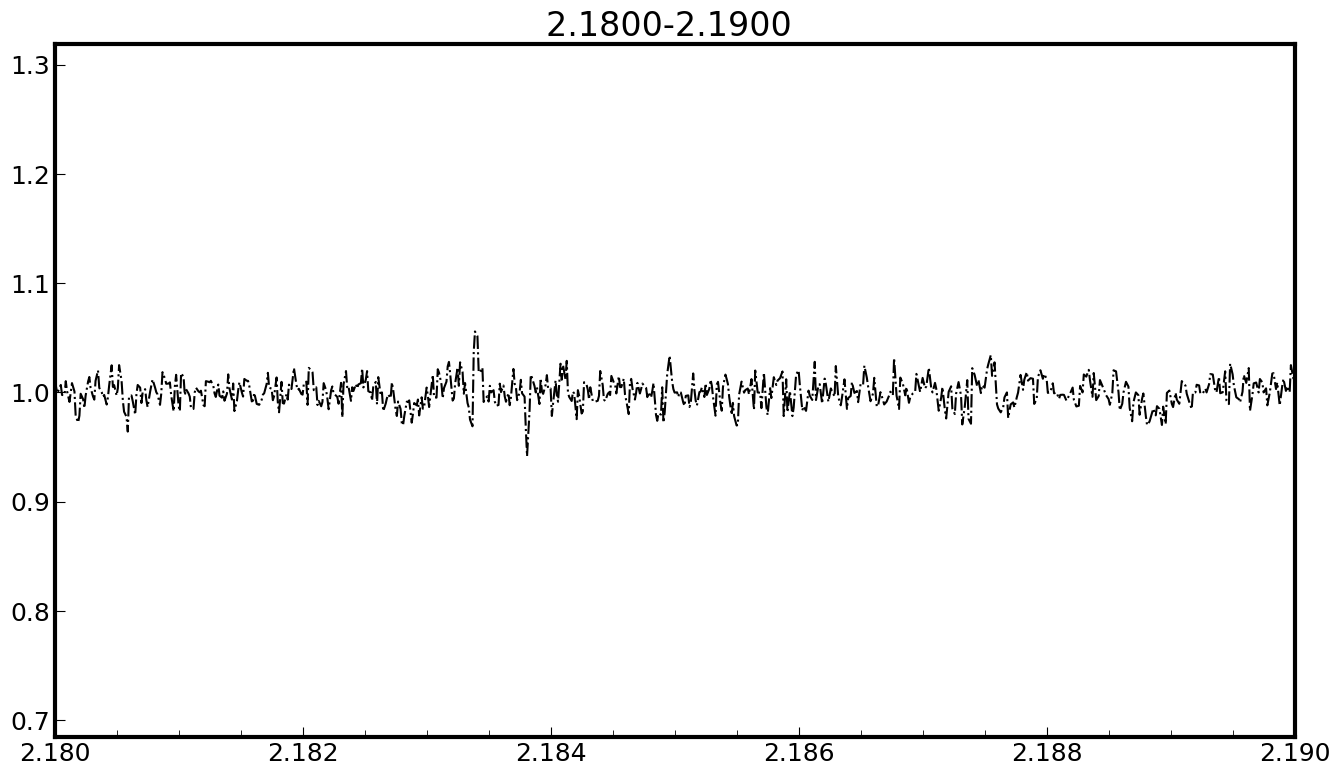

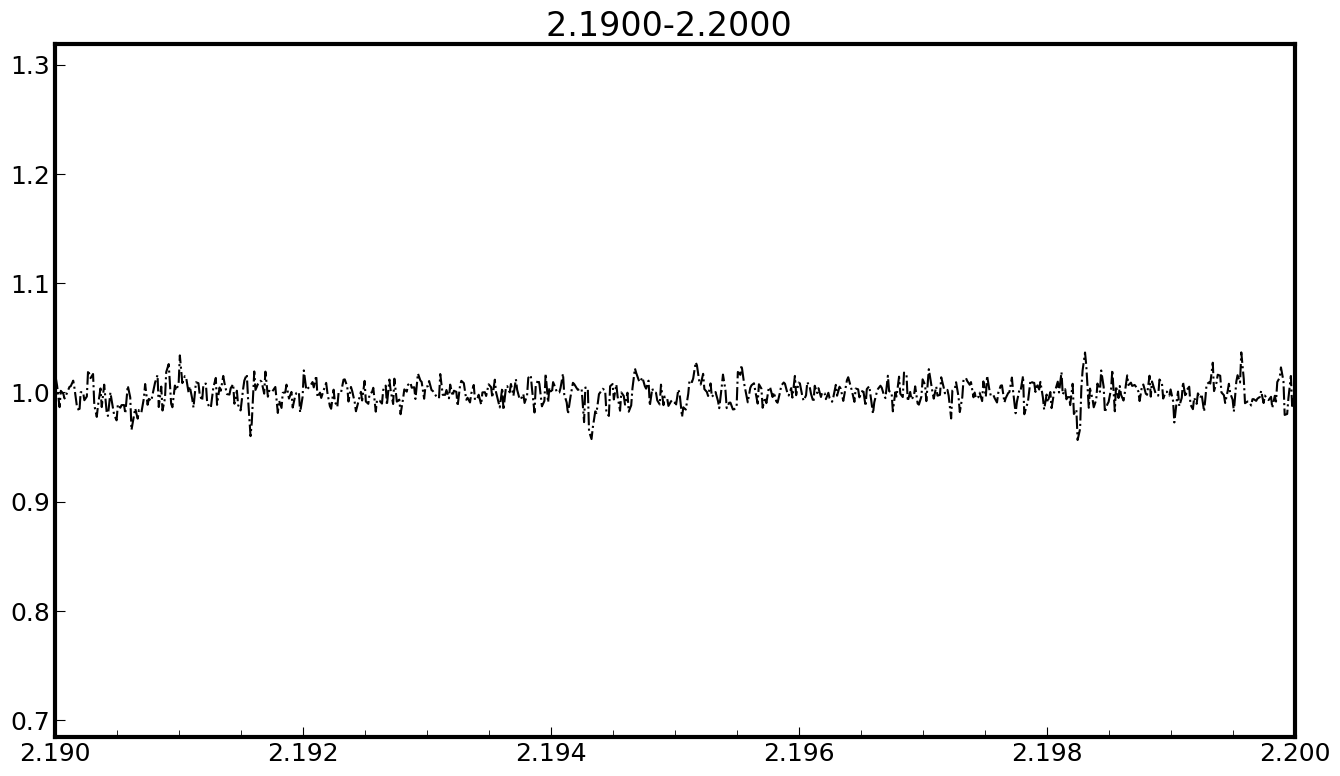

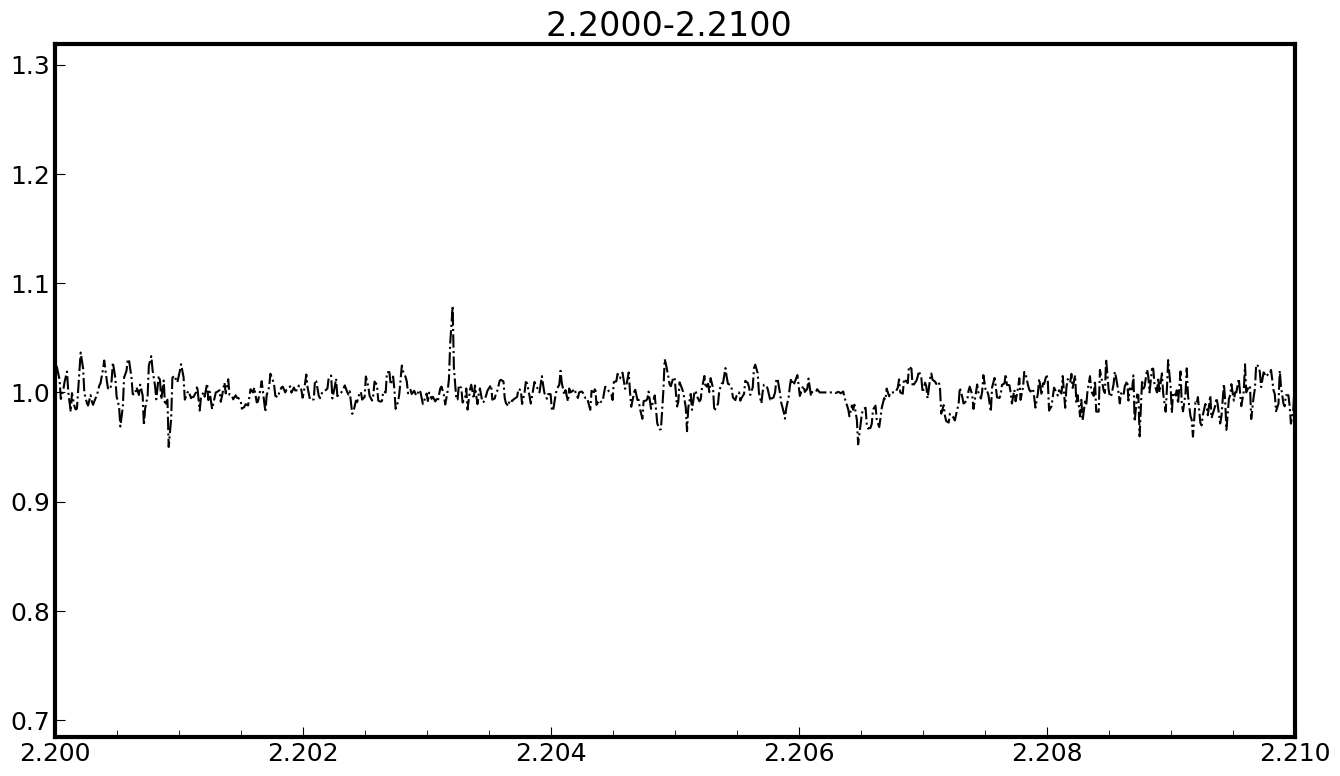

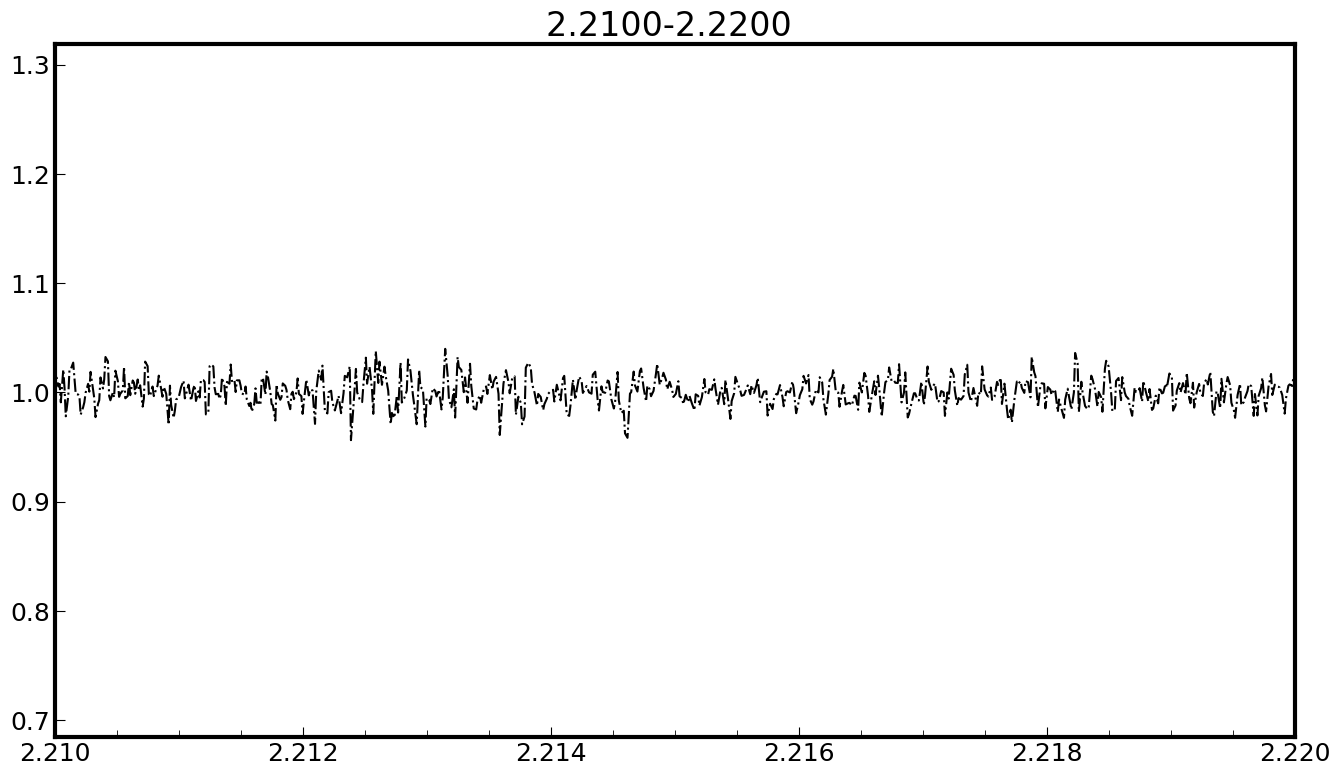

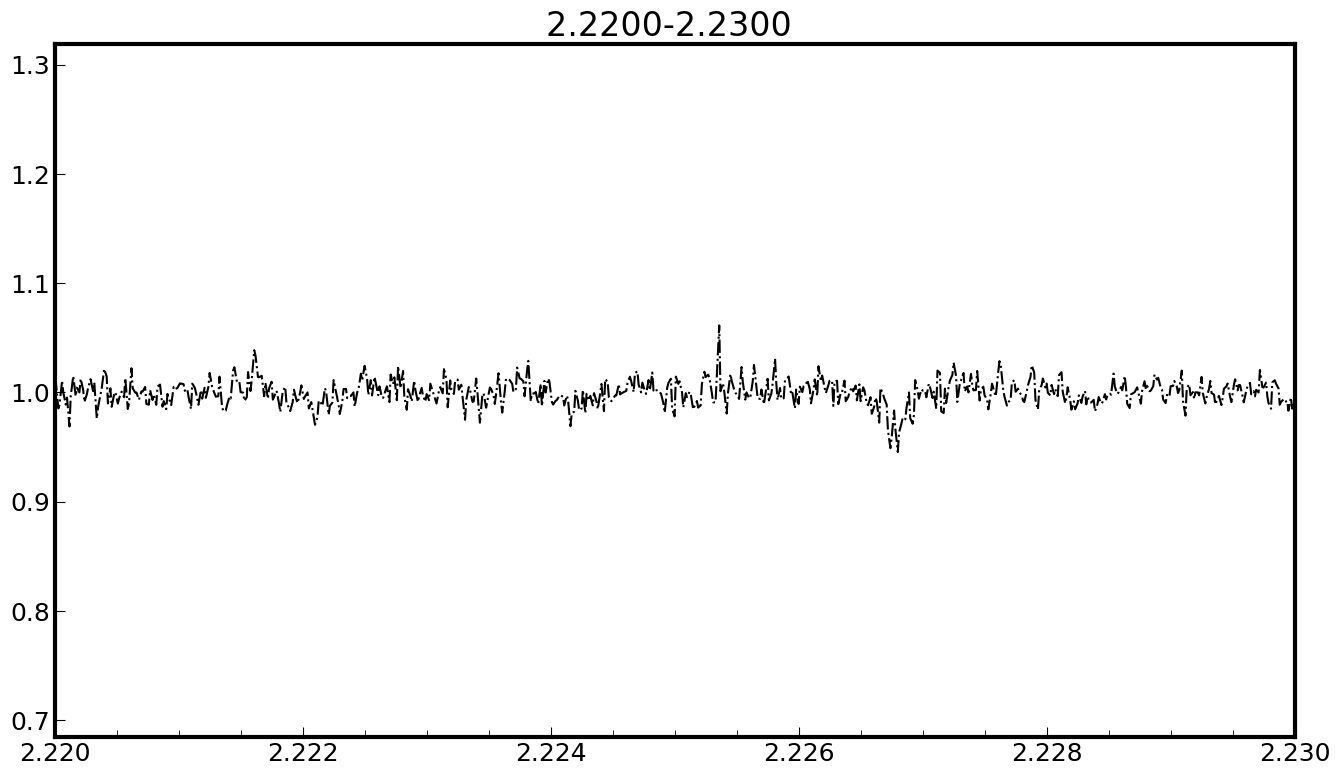

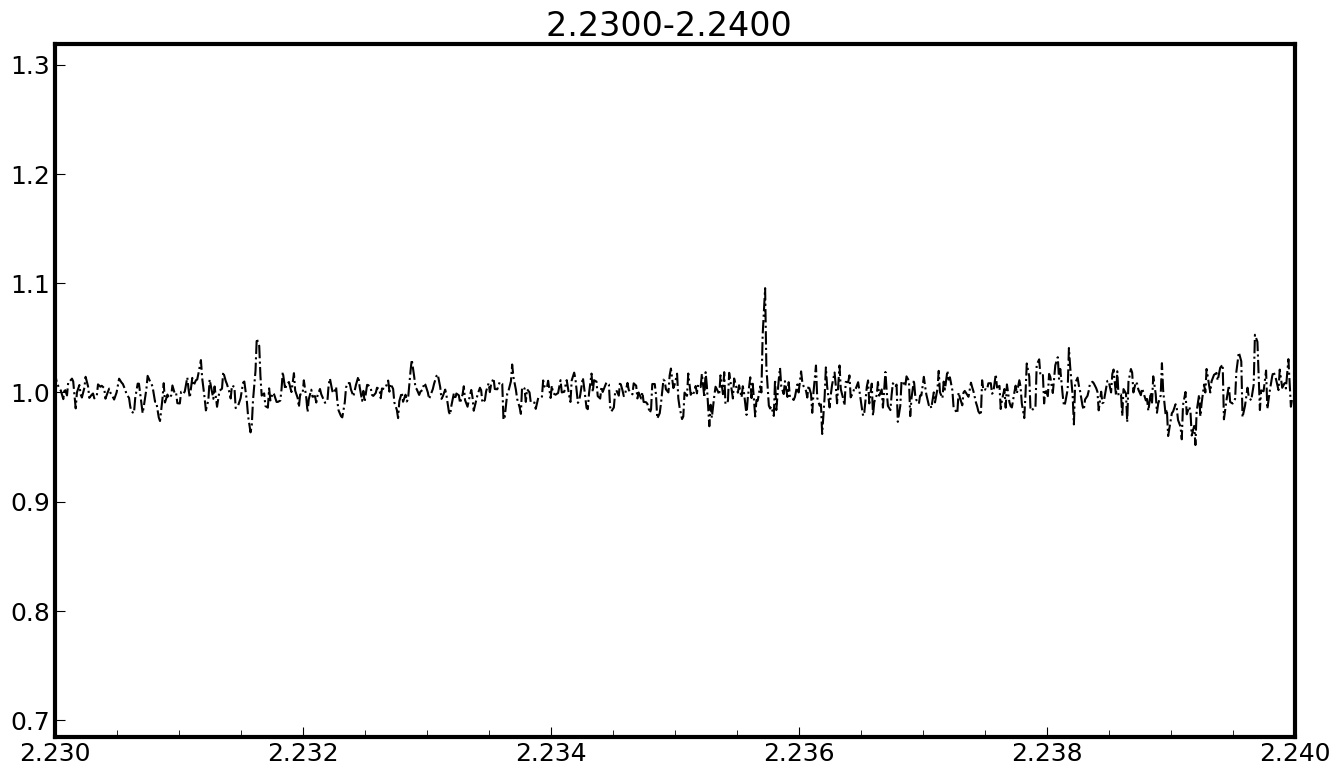

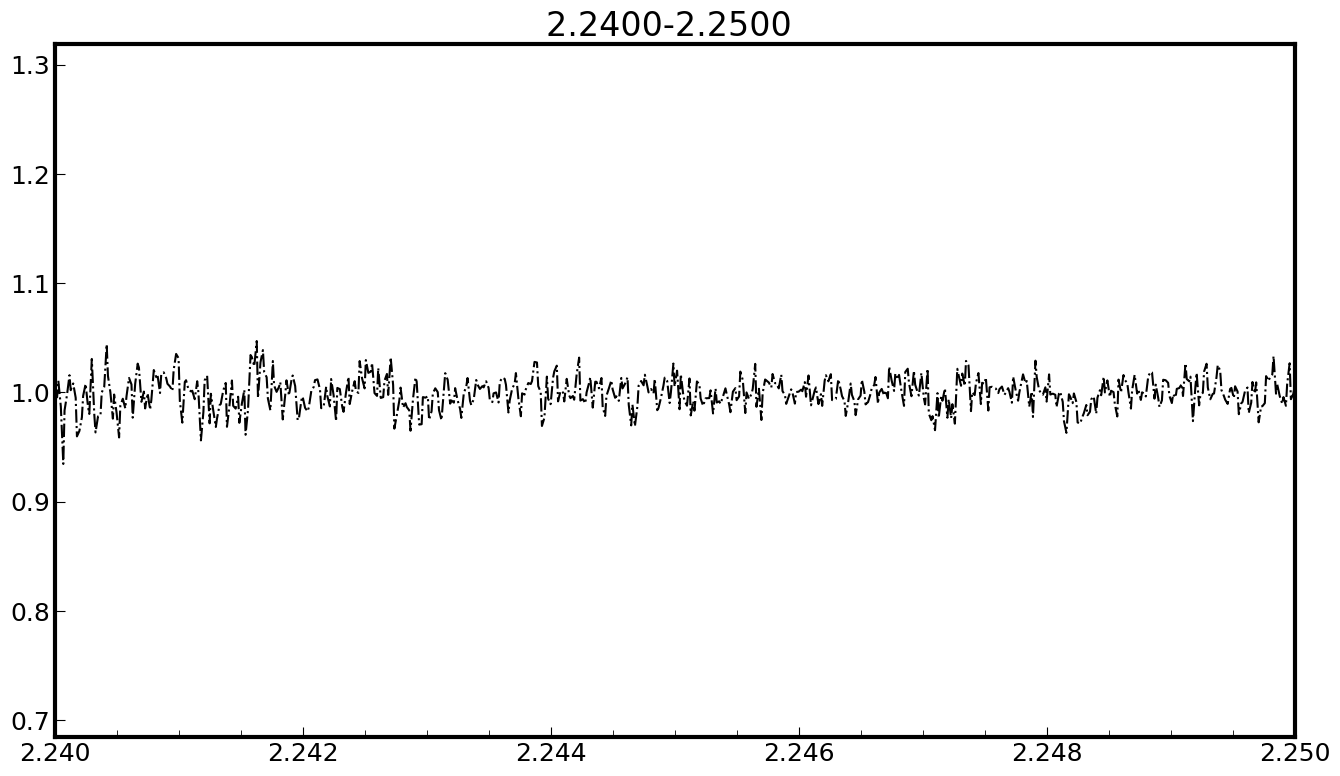

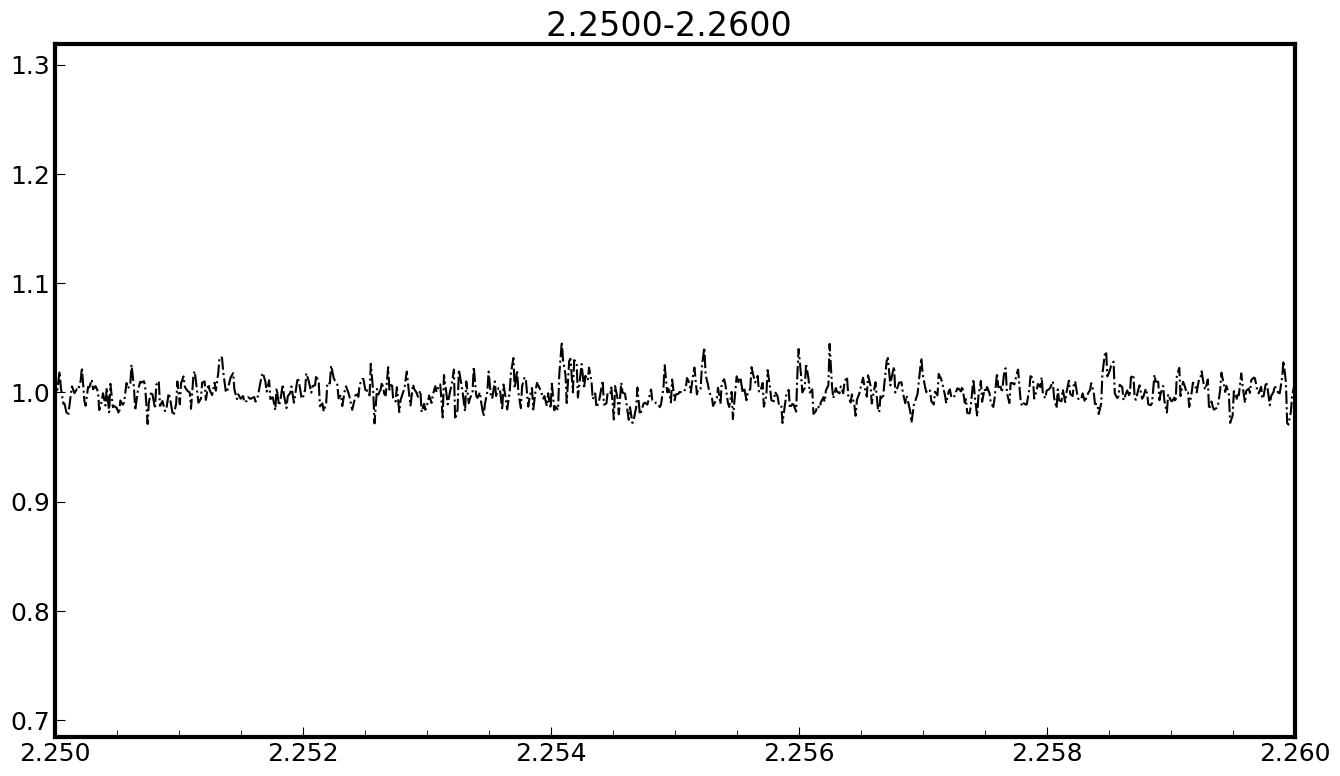

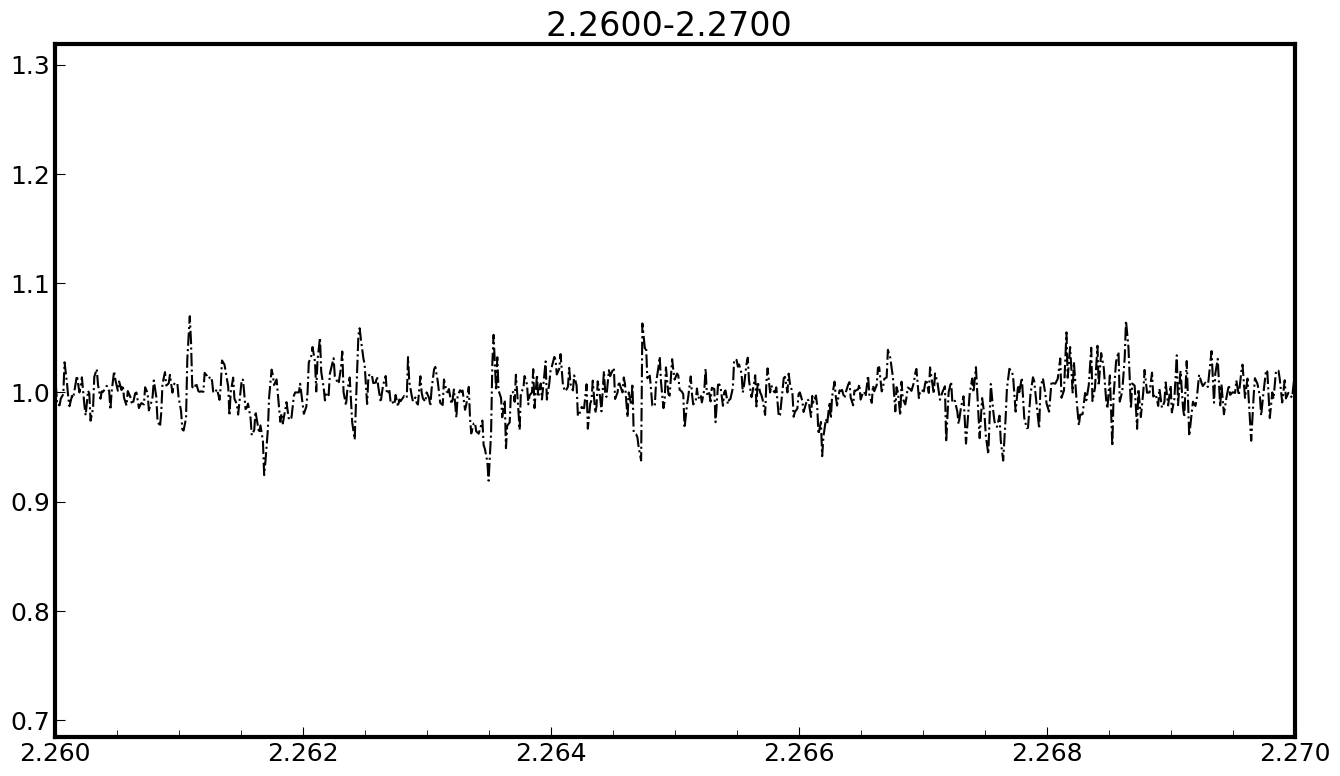

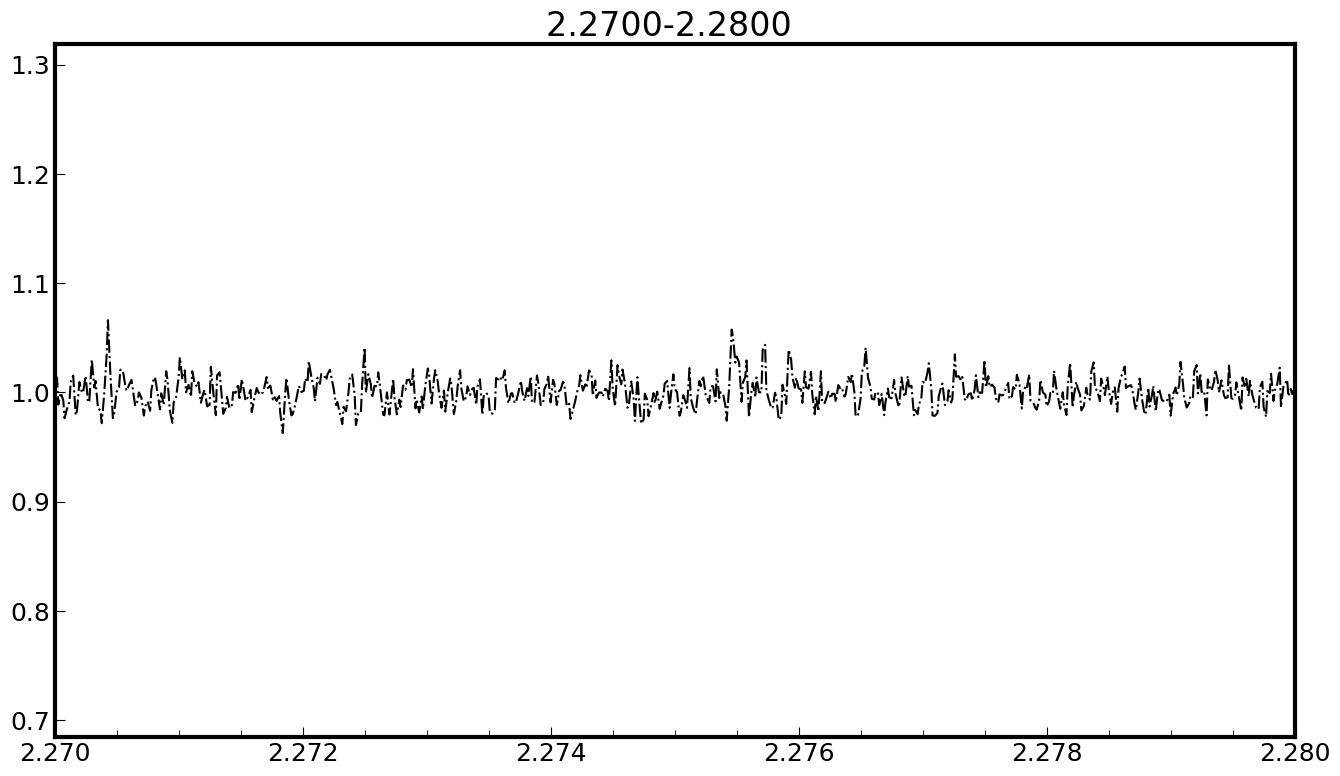

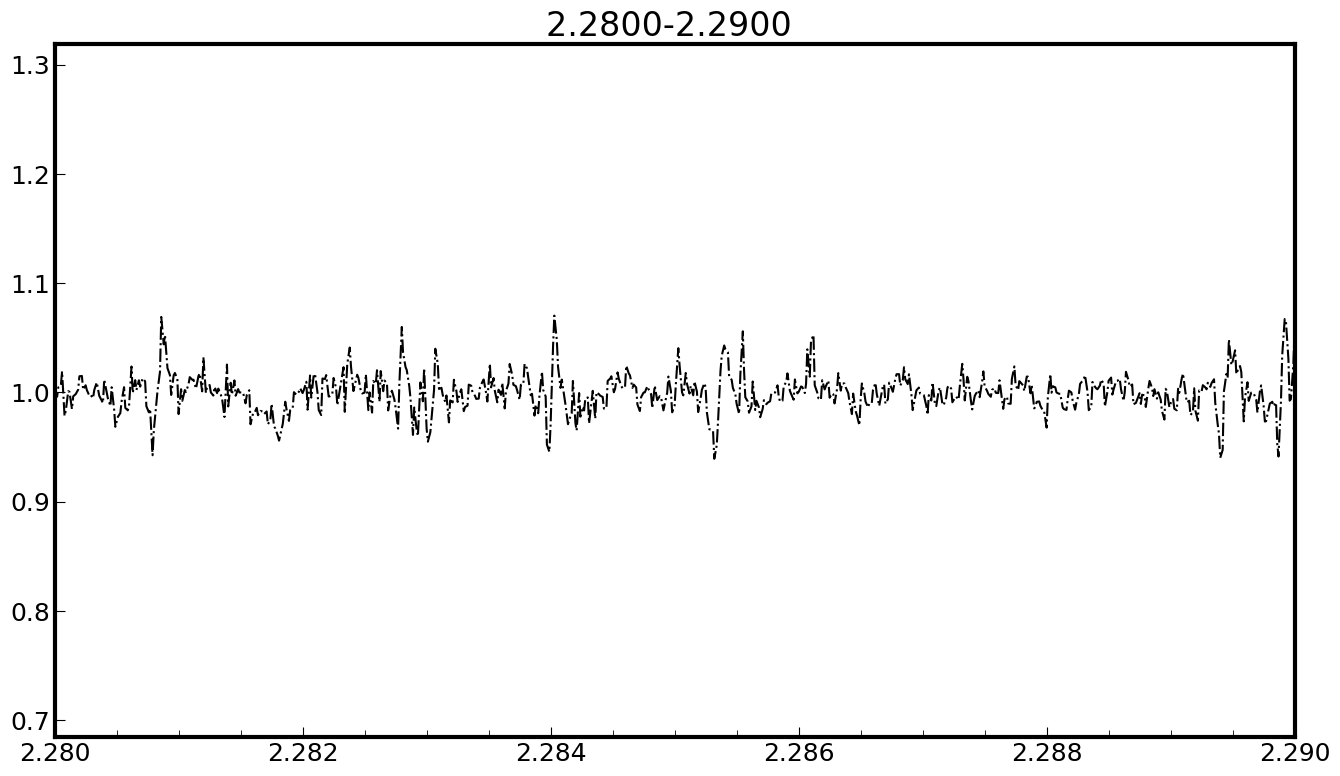

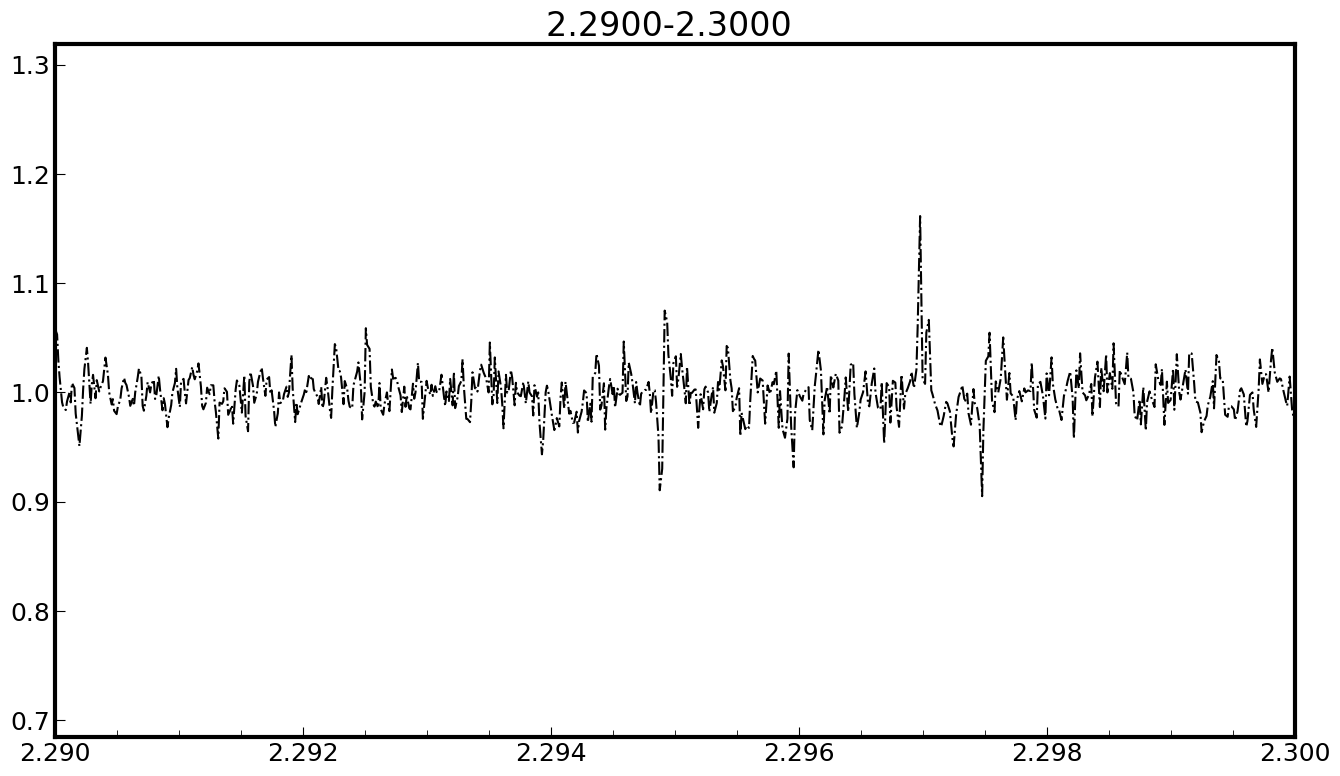

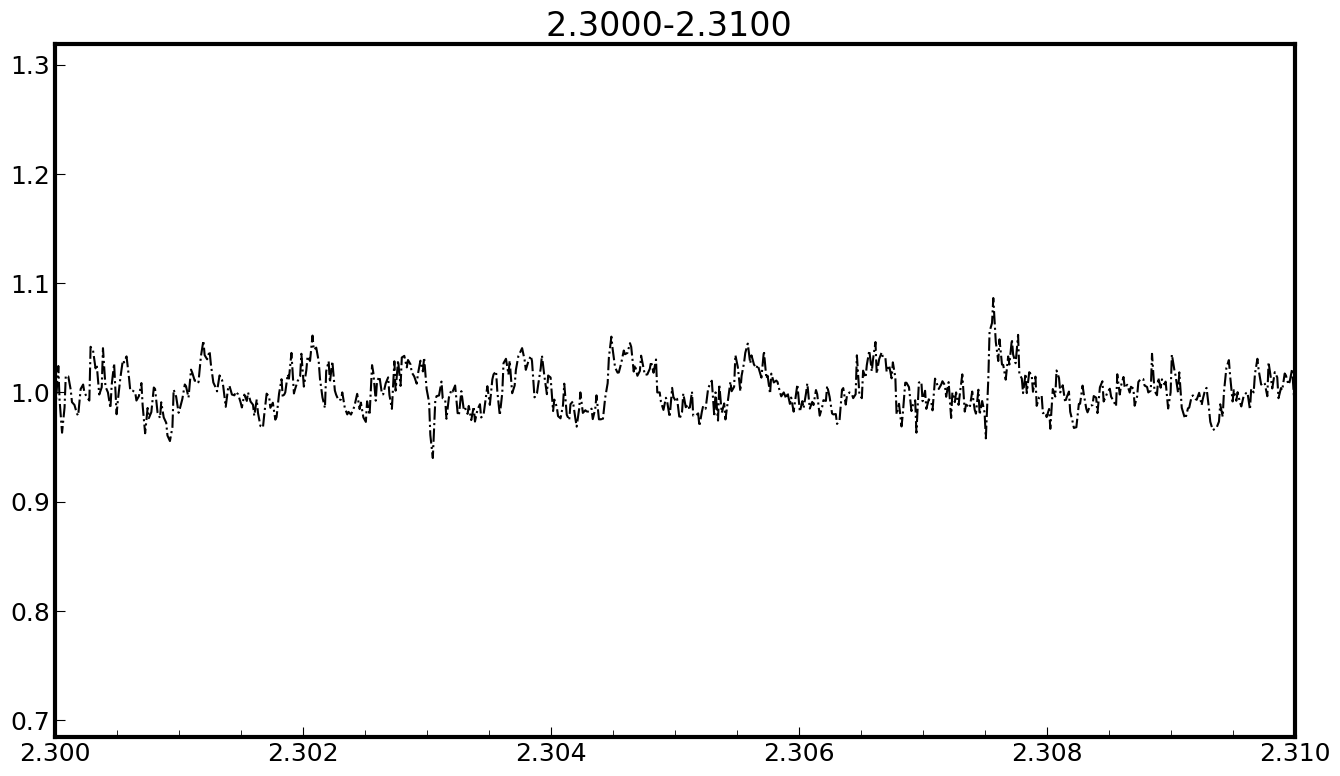

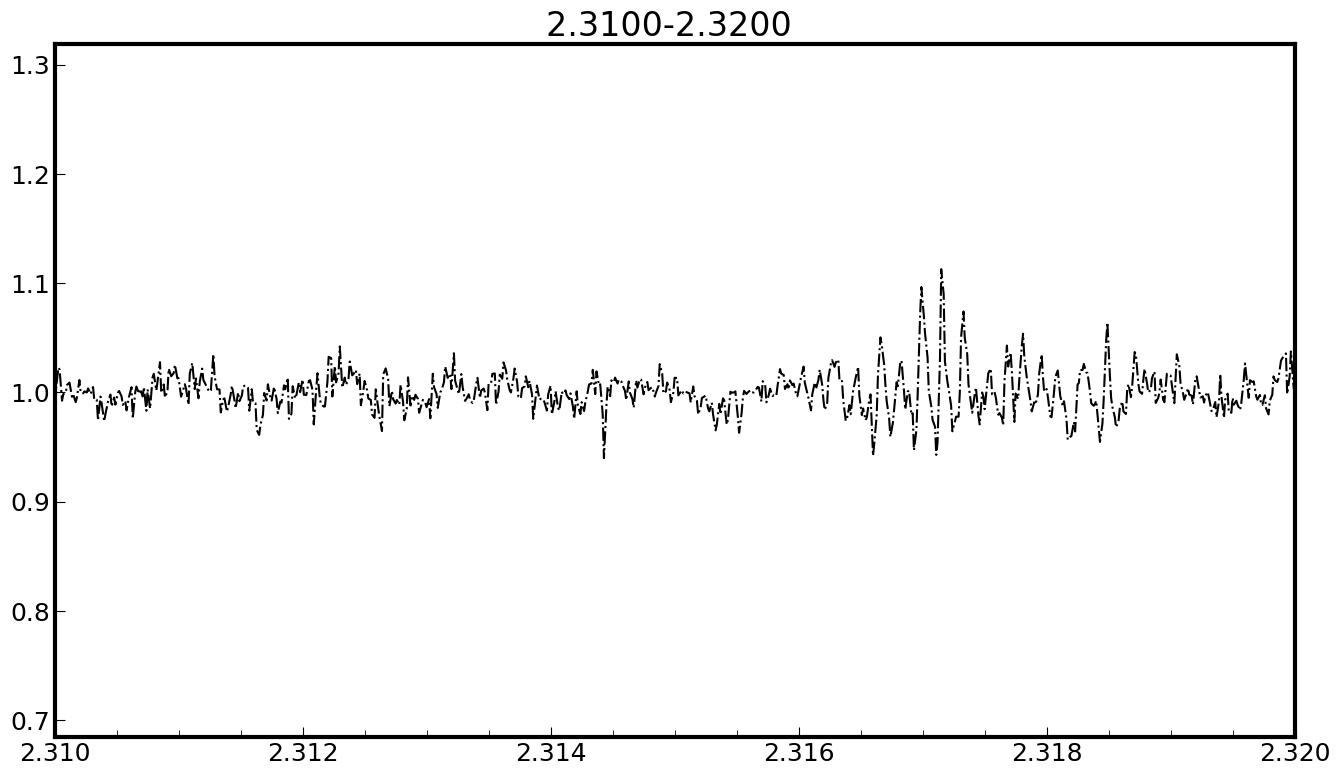

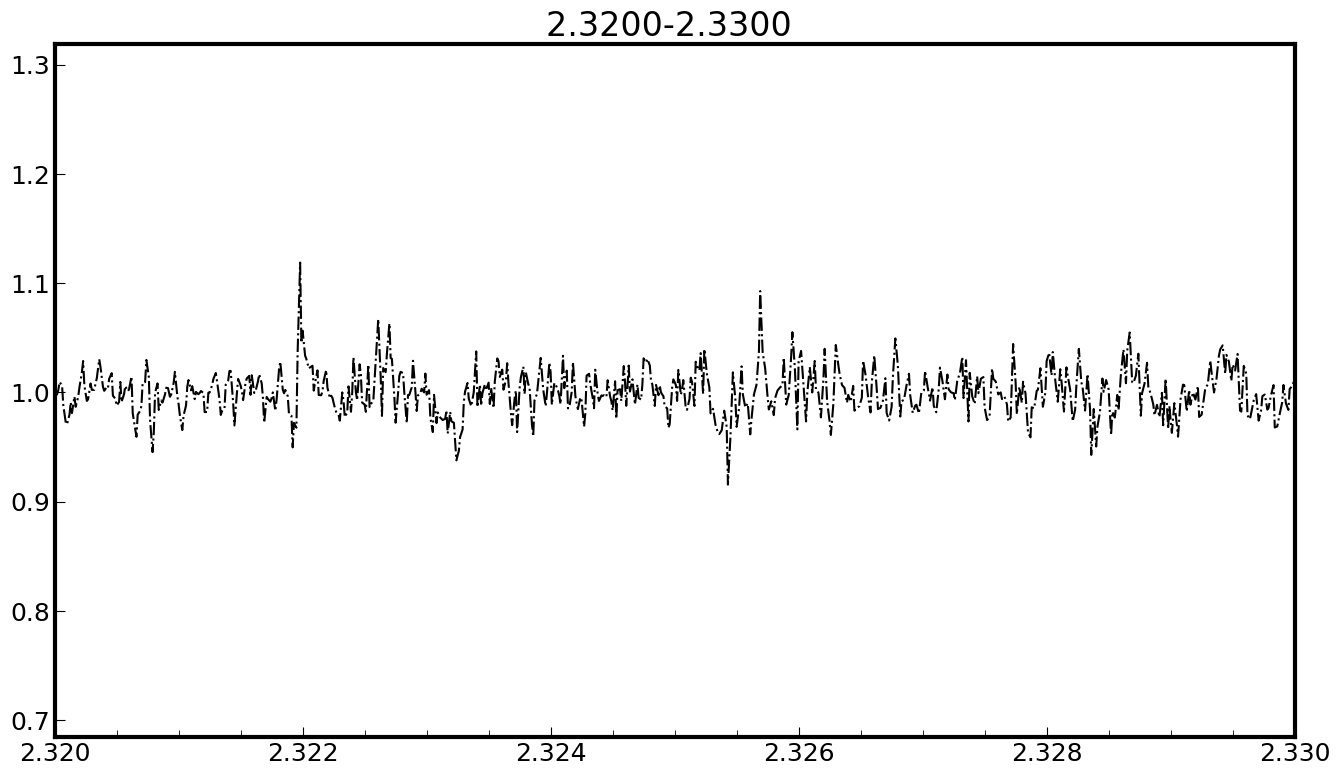

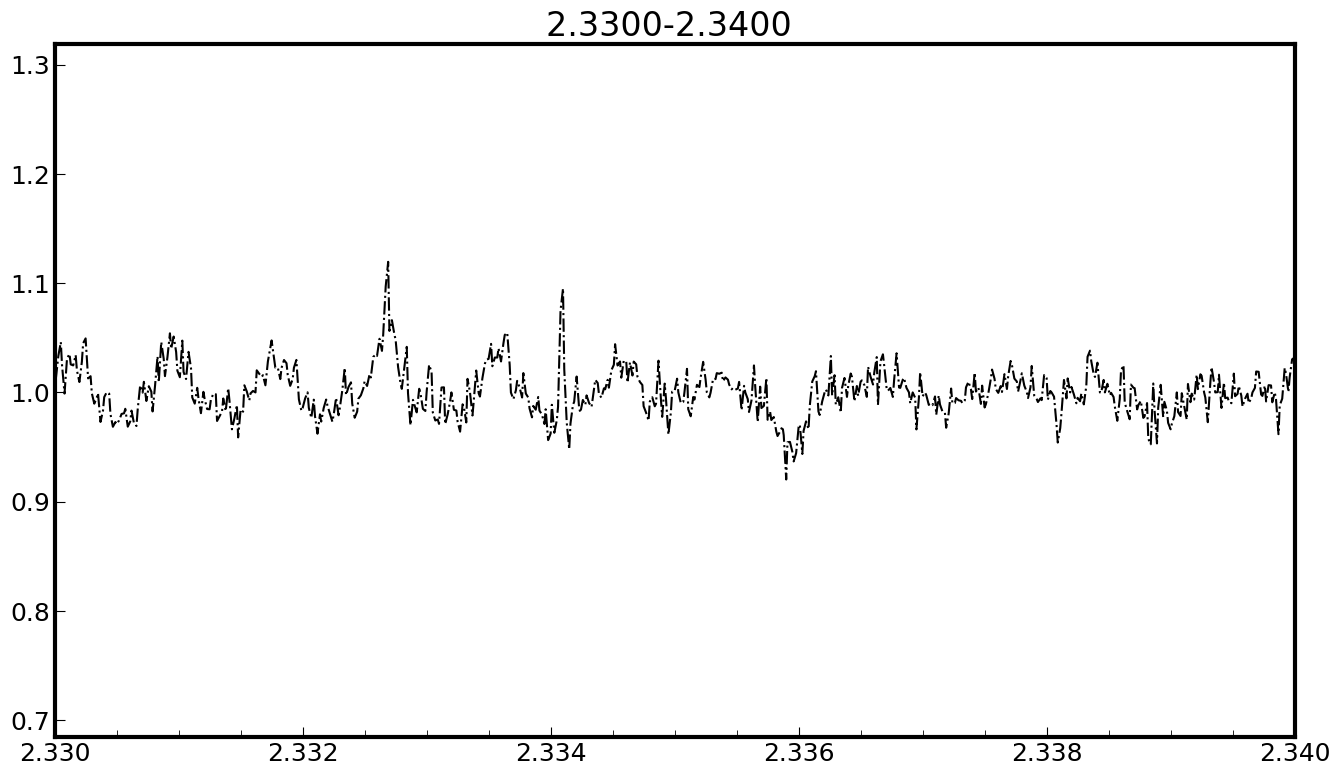

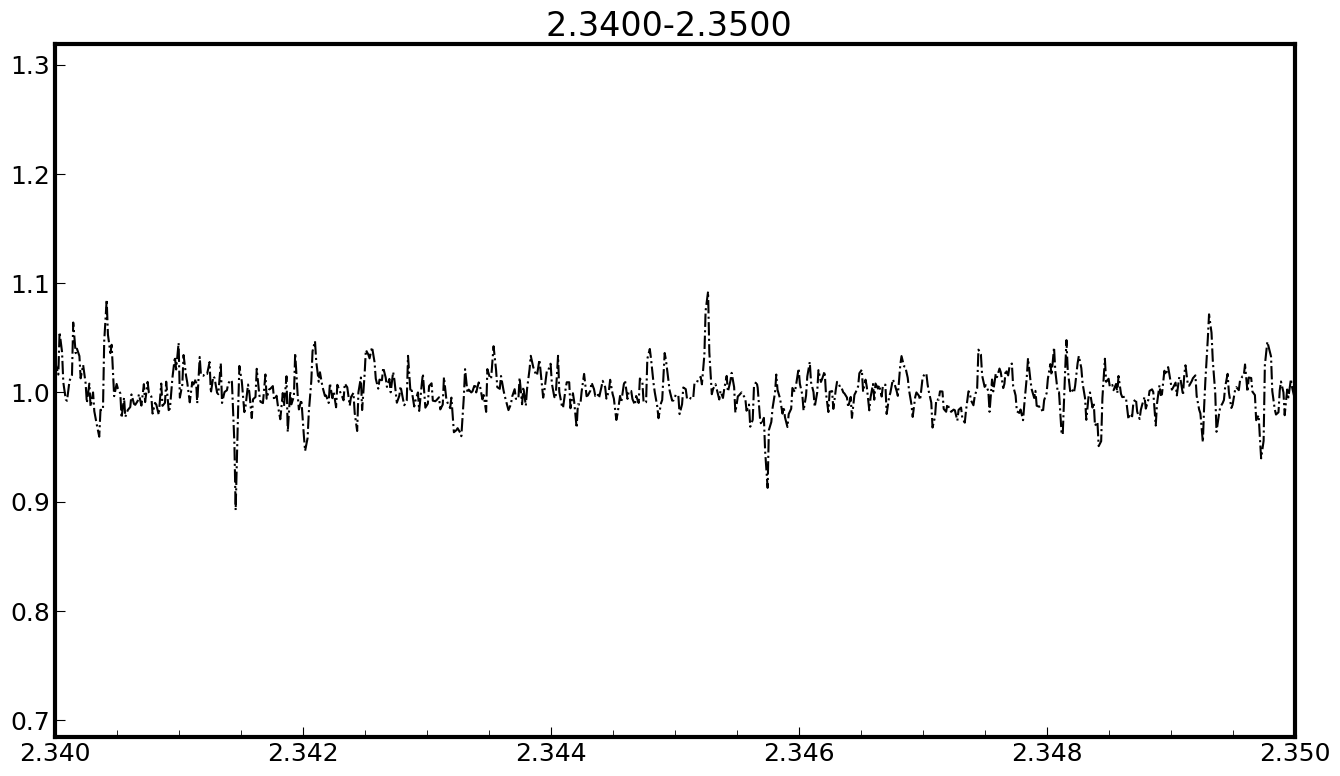

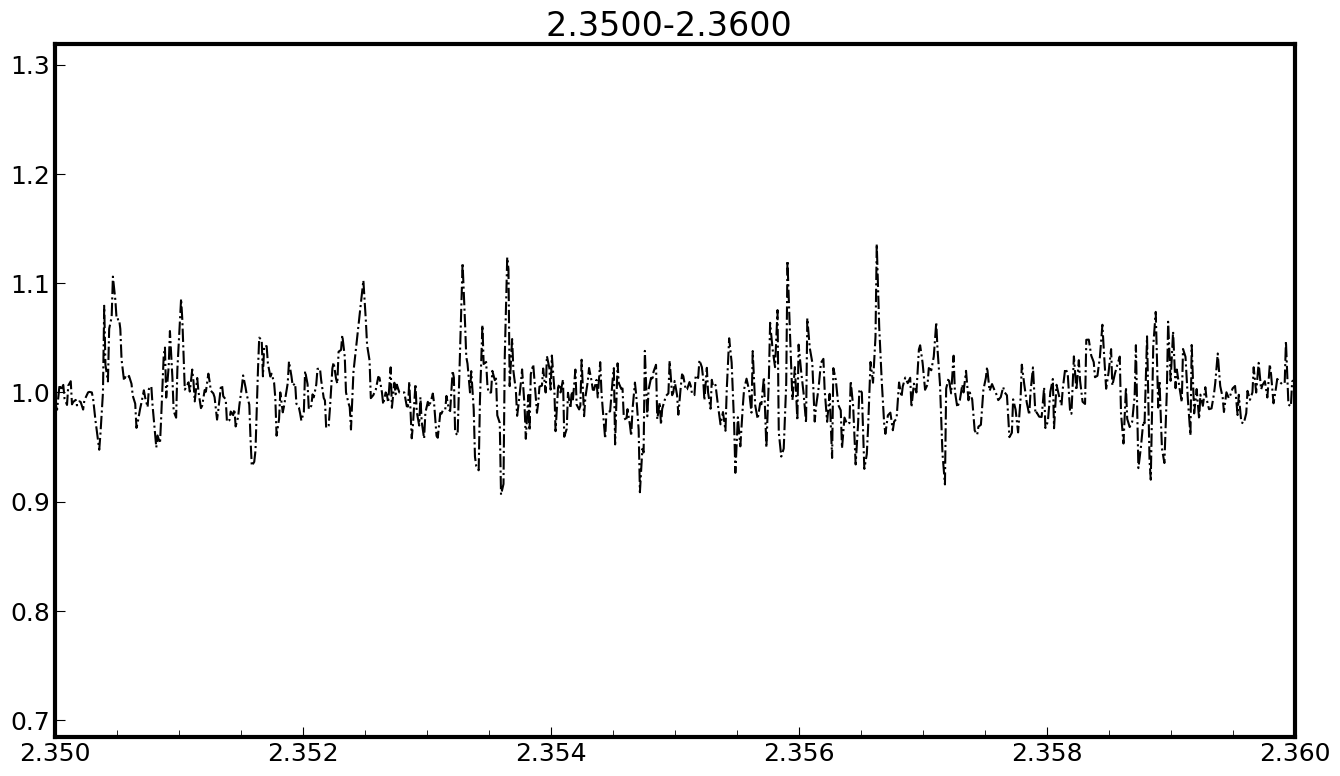

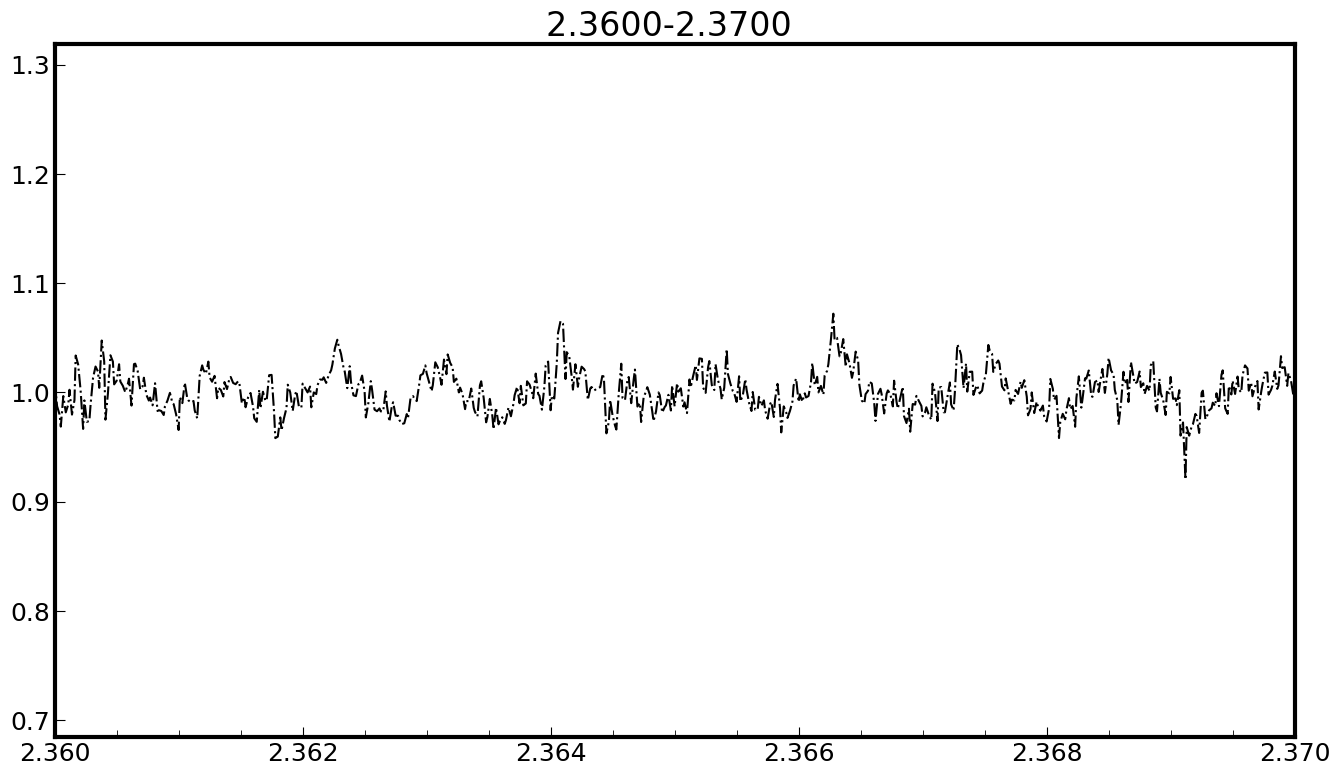

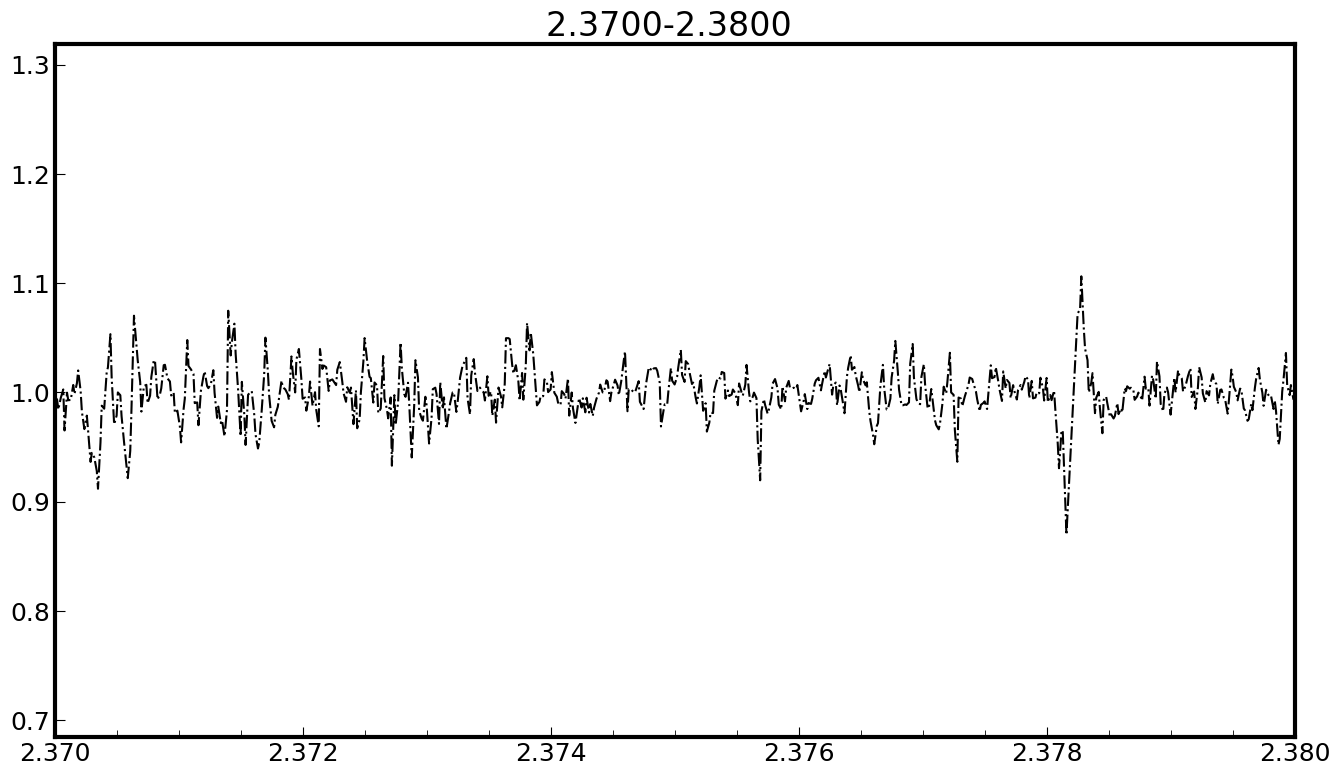

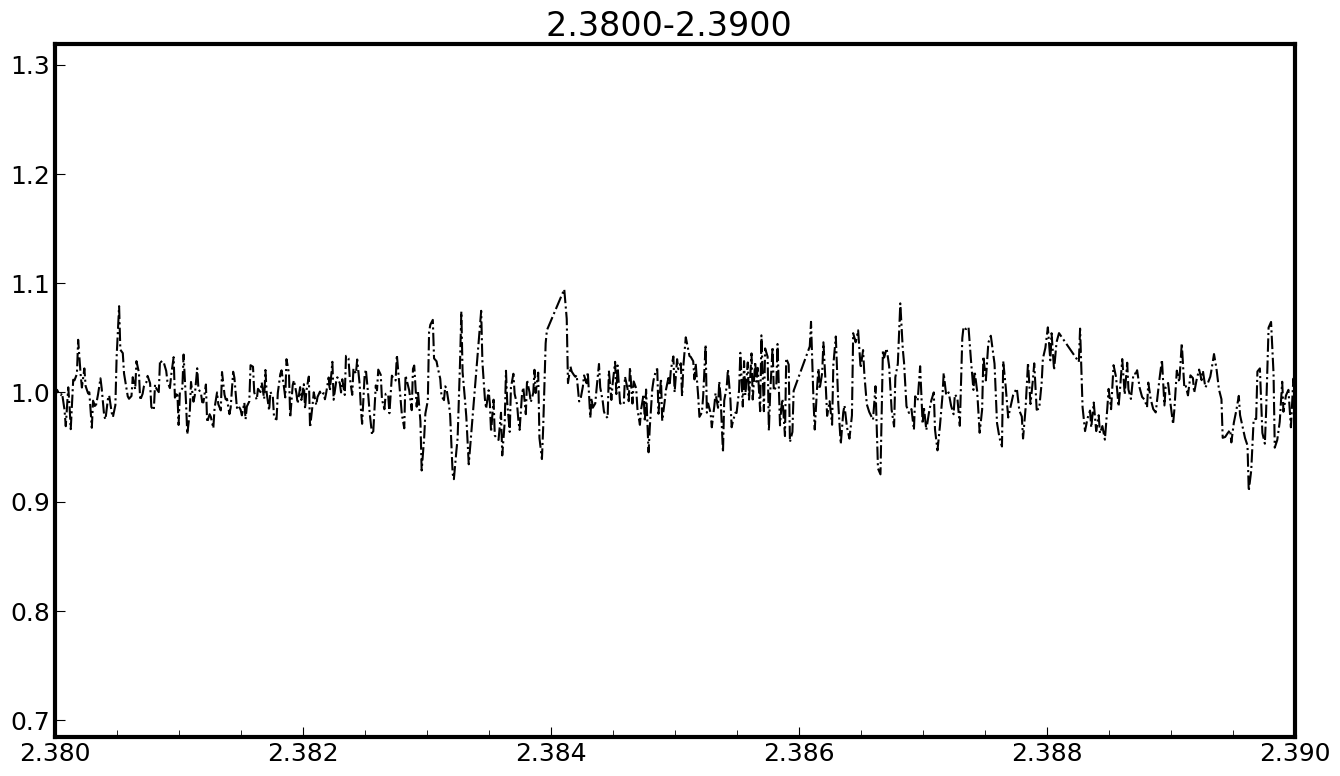

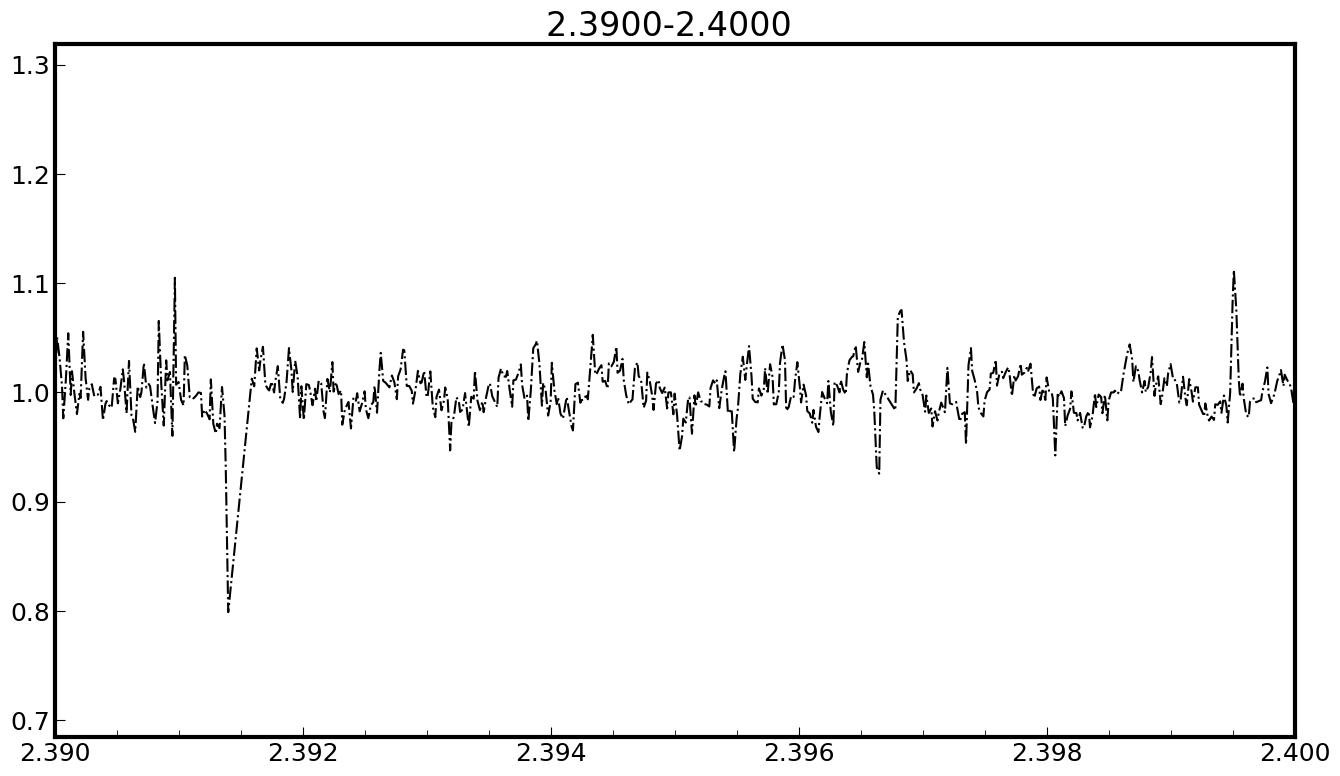

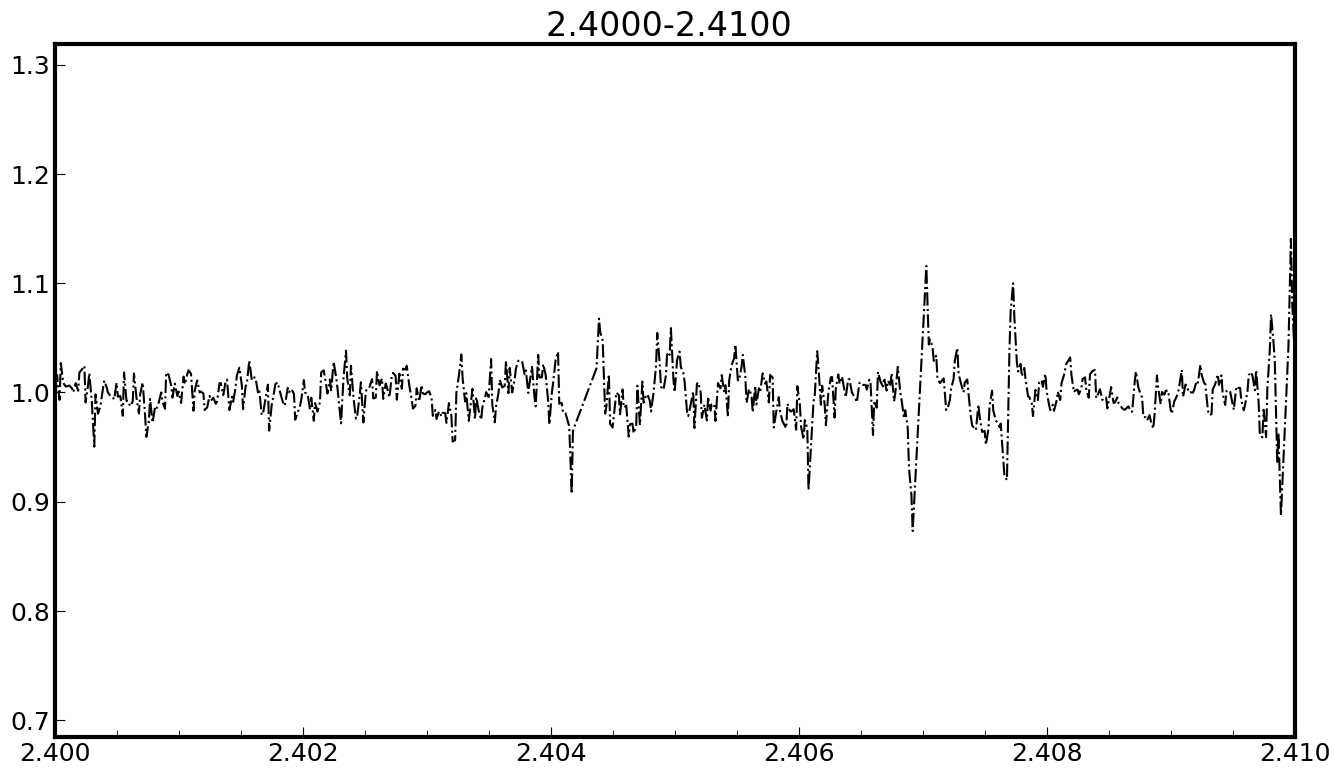

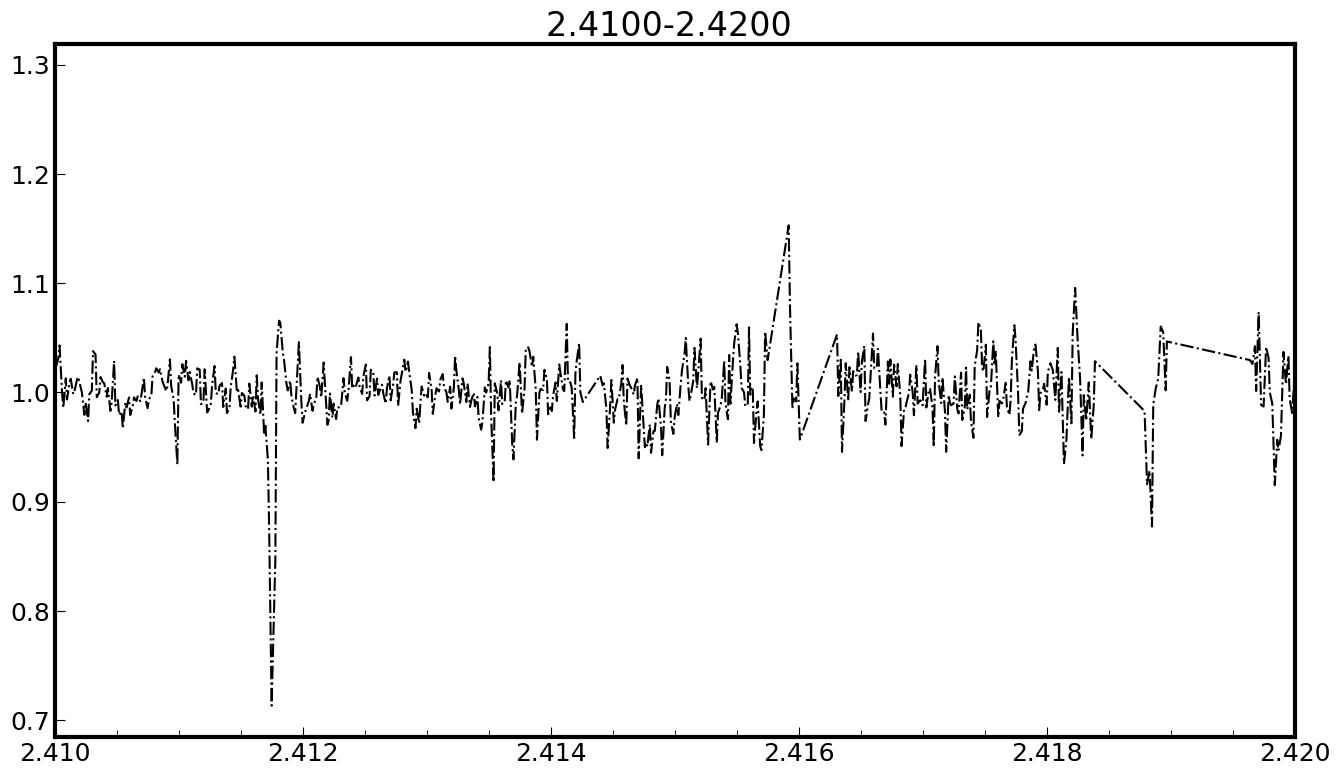

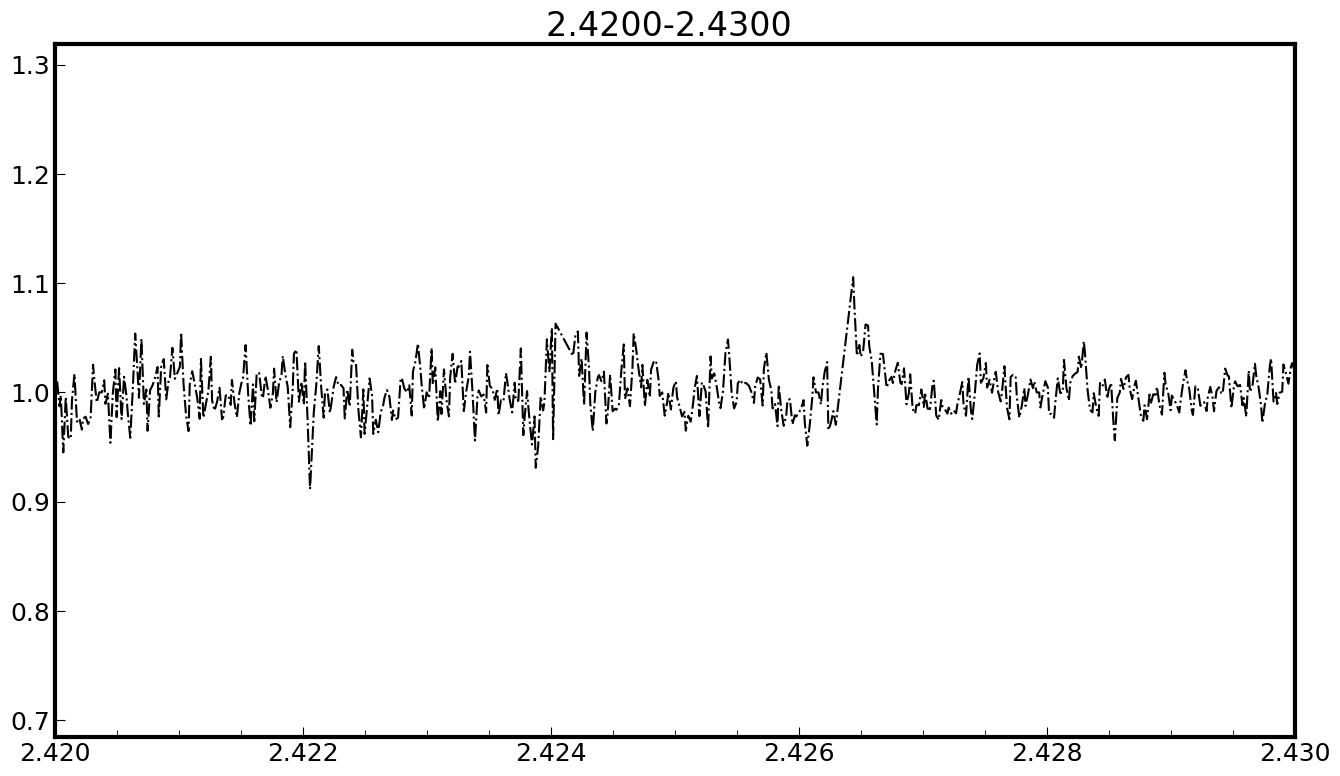

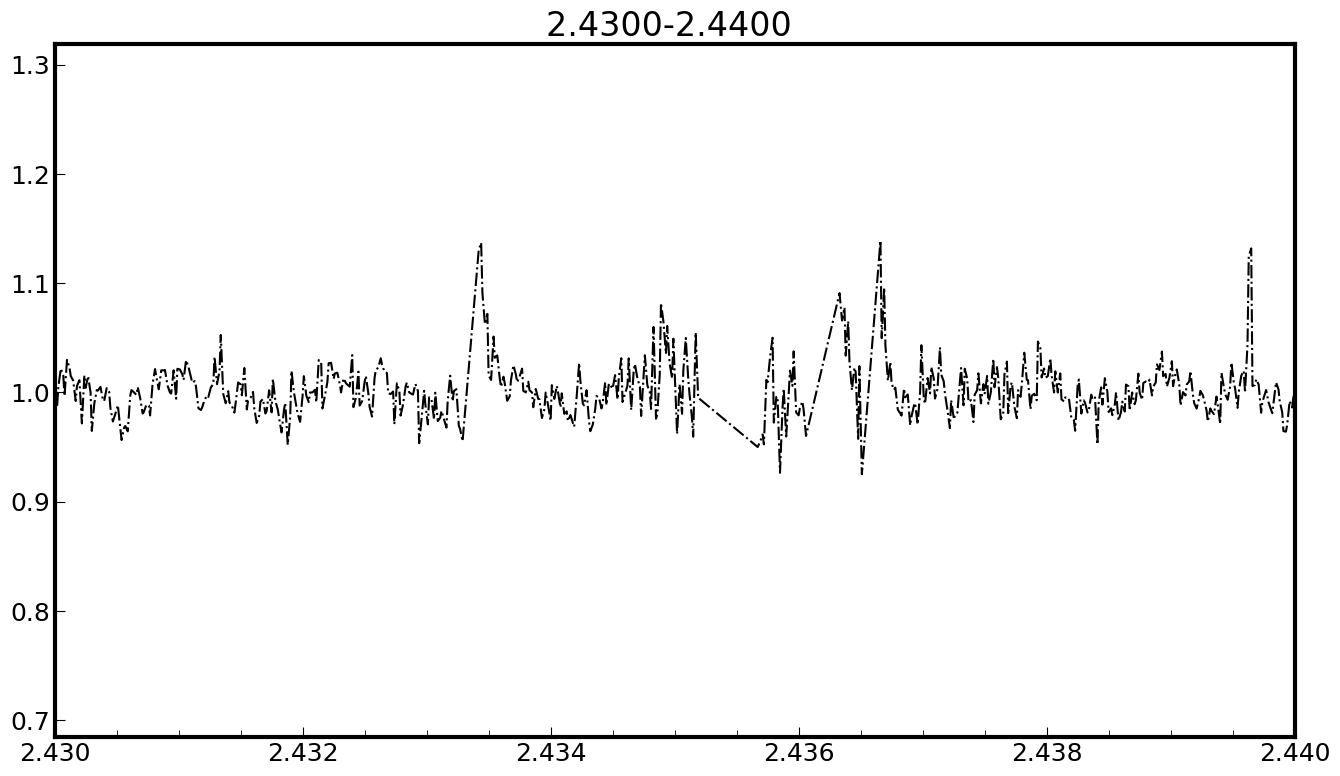

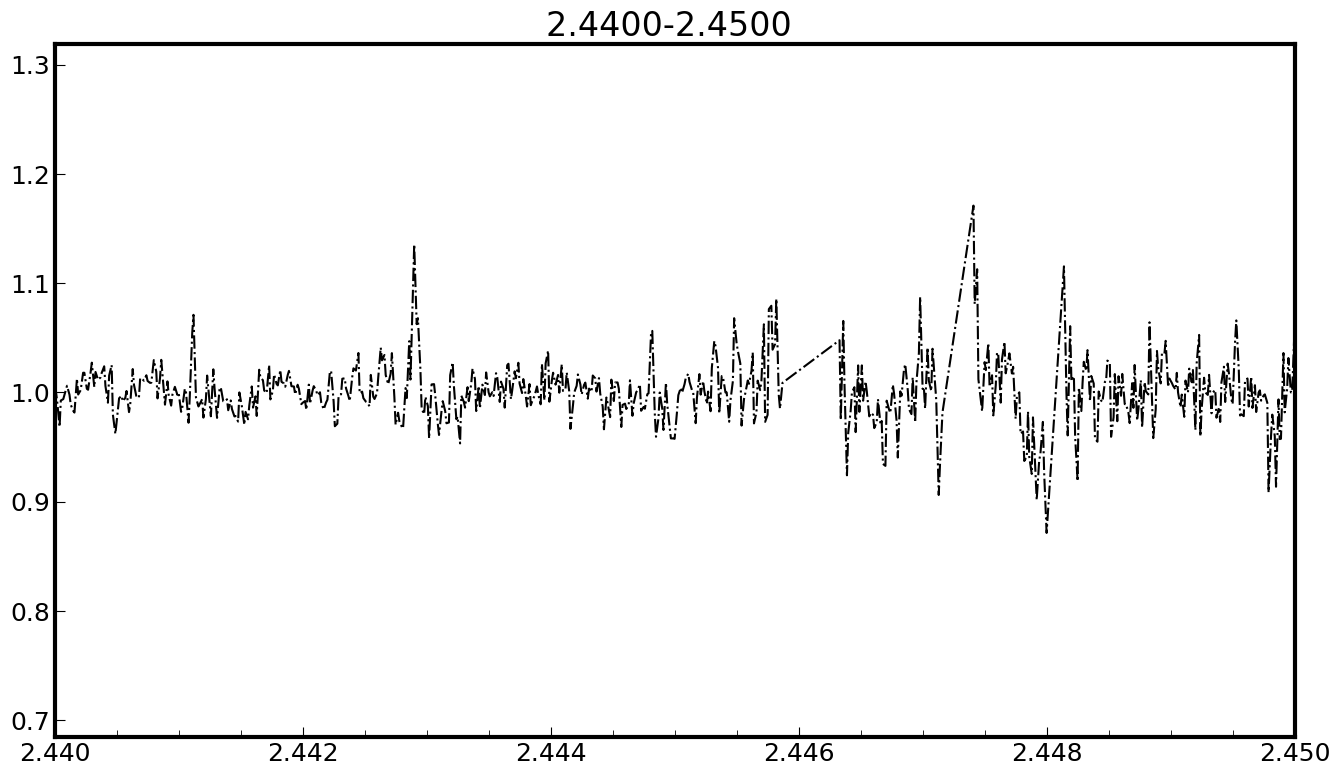

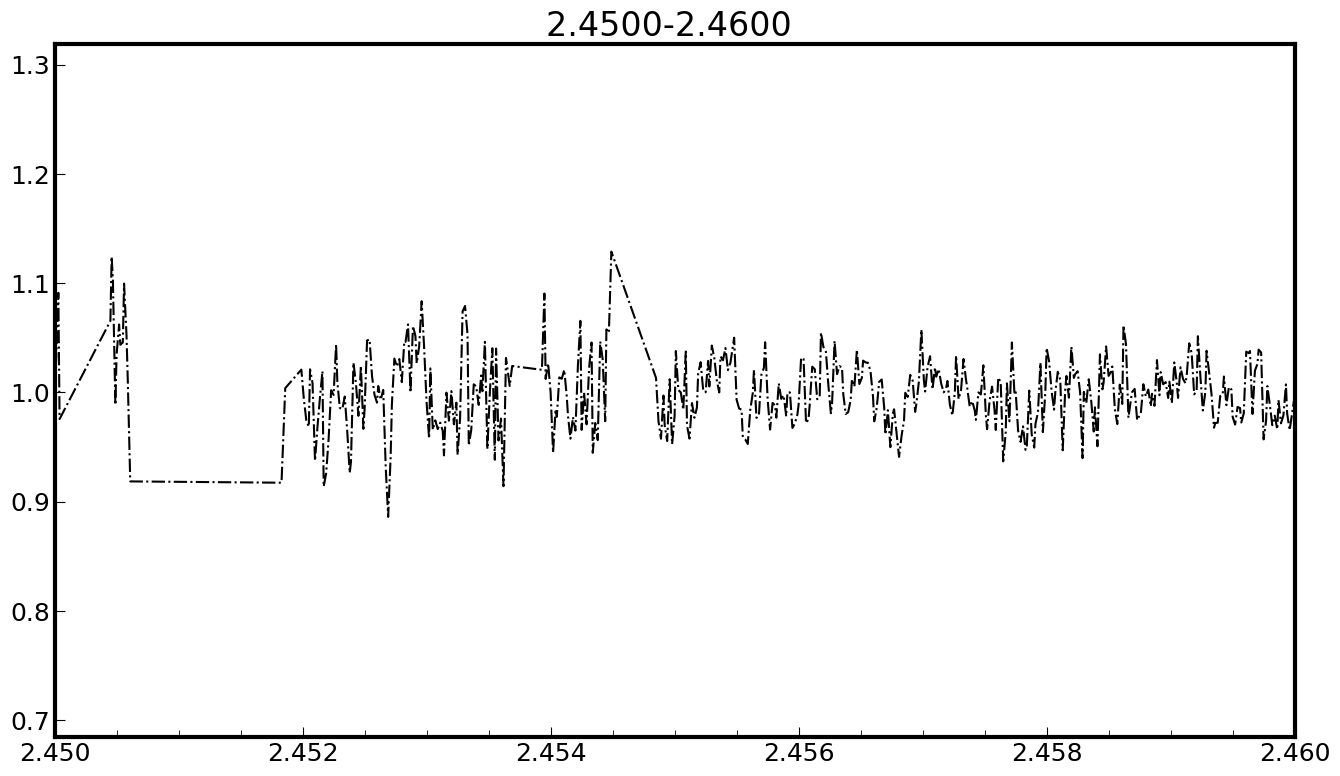

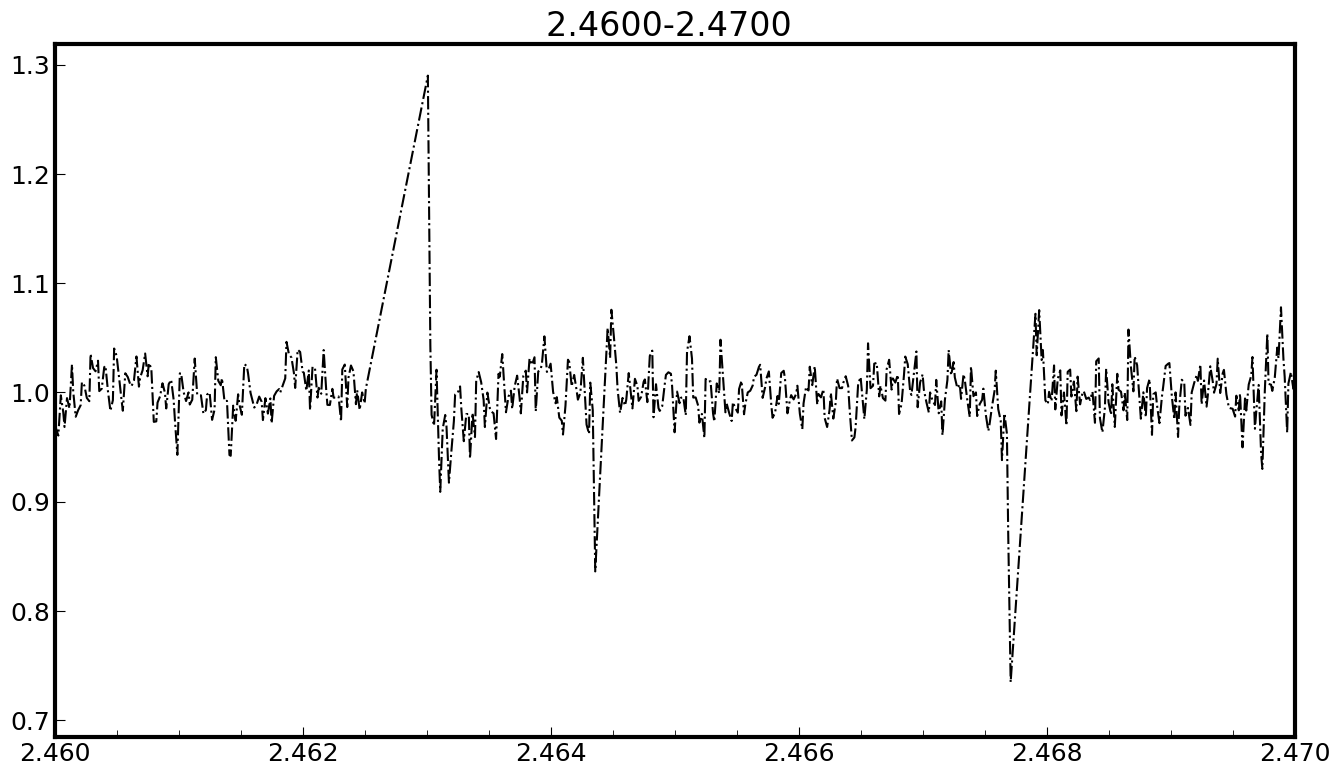

KeyboardInterrupt: 

In [23]:
spec_step = 0.01 # micron steps
# cont_fit_stack = np.zeros((len(flux_stack[:,0]),len(merged_standard_files)))
test = np.arange(2.1, 2.48, spec_step)  # arange to step through the spectrum in spec_step micron increments
flux_const = np.linspace(0,1,len(standard_list))
norm_flux_stack = np.zeroes(len())

for standard in range(len(standard_list)):
    # Assuming ig.get_fitsdata returns wavelen, flux, snr
    wavelen, flux, snr = ig.get_fitsdata(standard_list['Source'][standard])
    
    norm_flux = flux/medfilt(flux,kernel_size = 51)

    for start in test:
        fig, ax = plt.subplots(figsize=(16, 9))
        end = start + spec_step  # Determine end step
        mask = (wavelen >= start) & (wavelen < end)
    # norm_flux = medfilt(flux,kernel_size = 51)

    # Plot spectrum and continuum fit
    # ax.plot(wavelen[mask], norm_flux[mask]+flux_const[standard], '-.', c='black')#, label='Spectrum {}'.format(standard))
        ax.plot(wavelen, (norm_flux)+(2*flux_const[standard]), '-.', c='black')#, label='Spectrum {}'.format(standard))
        ax.set_xlim(start,end) # set xlim based on start and end wavelength values
    # ax.set_ylim(0.8,2.5)
    # ax.plot(wavelen[mask], flux[mask] / cont_fit[mask], '-', mfc='black', mec='black', c='black')  # masked flux
        ax.set_title( f'{start:.4f}-{end:.4f} ') # make title
    
    # ax.set_ylim(0,4) #

    line_mask = (lines_table['Observed'] >= start) & (lines_table['Observed'] <= end) # bitwise conditional

    label_added = {}  # Reset label_added dictionary for each plot
    for spectrum, color in zip(mask_list,color_list):
        for i in range(len(lines_table[line_mask & spectrum])):
            spec_label = lines_table[line_mask & spectrum]['Spectrum'][0]  # Get the spectrum label
            if spec_label not in label_added:  # Check if label has been added to the legend
                plt.axvline(lines_table[line_mask & spectrum]['Observed'][0], ymin=0, ymax=0, ls='-', c=color, label=spec_label)
                label_added[spec_label] = True  # Mark label as added
            plt.axvline(lines_table[line_mask & spectrum]['Observed'][i],ls=':',lw=2, c=color) # ymin= 0.95 - 0.05 * list(label_added.keys()).index(spec_label), ymax = 1 - 0.05 * list(label_added.keys()).index(spec_label)

    # plt.tight_layout()
    plt.legend(framealpha=0.9,facecolor='white',labelcolor='black')
    # plt.savefig('./atomic_lines_figs/'+f'{start:.4f}-{end:.4f}.png') # save each section as .png
    plt.show()

In [14]:
lines_table[(ti1_mask) & (lines_table['Observed'] > 2.22) & (lines_table['Observed'] < 2.23)]

<Table length=6>
Spectrum Observed    Ritz   Transition ... Type   TP   Line 
  str5   float64    str18    float64   ... str5 str17 str20 
-------- -------- --------- ---------- ... ---- ----- ------
    Ti I  2.22045 2.2204483   4503.592 ...   --    -- L10989
    Ti I 2.221729 2.2217280   4500.998 ...   -- T8000 L10989
    Ti I  2.22389 2.2238911   4496.625 ...   -- T8000 L10989
    Ti I 2.226152  2.226156   4492.057 ...   --    -- L10989
    Ti I 2.228011 2.2280086   4488.309 ...   -- T8000 L10989
    Ti I 2.228901  2.228906   4486.515 ...   --    -- L10989

In [15]:
wavelen[mask][flux[mask].argmin()]

2.4711999893188477

[-5.54630780e-05  2.22395491e+00  1.56335591e-04  9.92597649e-01]
[-3.41361858e+00  2.22387837e+00  2.36939555e-02  5.84777822e+01]
[-1.82171385e-05  2.22418557e+00  1.10682958e-04  1.00236406e+00]
[-9.58325267e+00  2.22389788e+00  2.56412012e-02  1.50047242e+02]
[-9.27506029e+00  2.22405622e+00  2.59306537e-02  1.43584868e+02]
[9.65150275e-06 2.22353848e+00 1.98372190e-04 9.48960294e-01]


a:\Anaconda\envs\astro\envs\muler_dev\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[0.77795889 0.79324776 0.18127298 0.97146435]
[-6.01196070e-05  2.22396088e+00  1.49792968e-04  9.87114402e-01]
[-5.95620527e-05  2.22411210e+00  1.18620619e-04  9.78298107e-01]
[-4.93202195e-05  2.22415234e+00  1.17634141e-04  1.00795142e+00]
[-1.03579196e+01  2.22396723e+00  2.75494682e-02  1.50922262e+02]
[-9.14422321e+00  2.22389788e+00  2.52539031e-02  1.45397261e+02]
[-1.33797456e+01  2.22393641e+00  2.92397773e-02  1.83553221e+02]
[-1.34719098e+01  2.22397035e+00  2.75443119e-02  1.96156910e+02]
[-1.35875229e+01  2.22391036e+00  2.72244900e-02  2.00052474e+02]
[-8.88060177e+00  2.22416969e+00  2.38106112e-02  1.49697326e+02]
[-5.67652825e-05  2.22412316e+00  1.90138482e-04  9.58564865e-01]


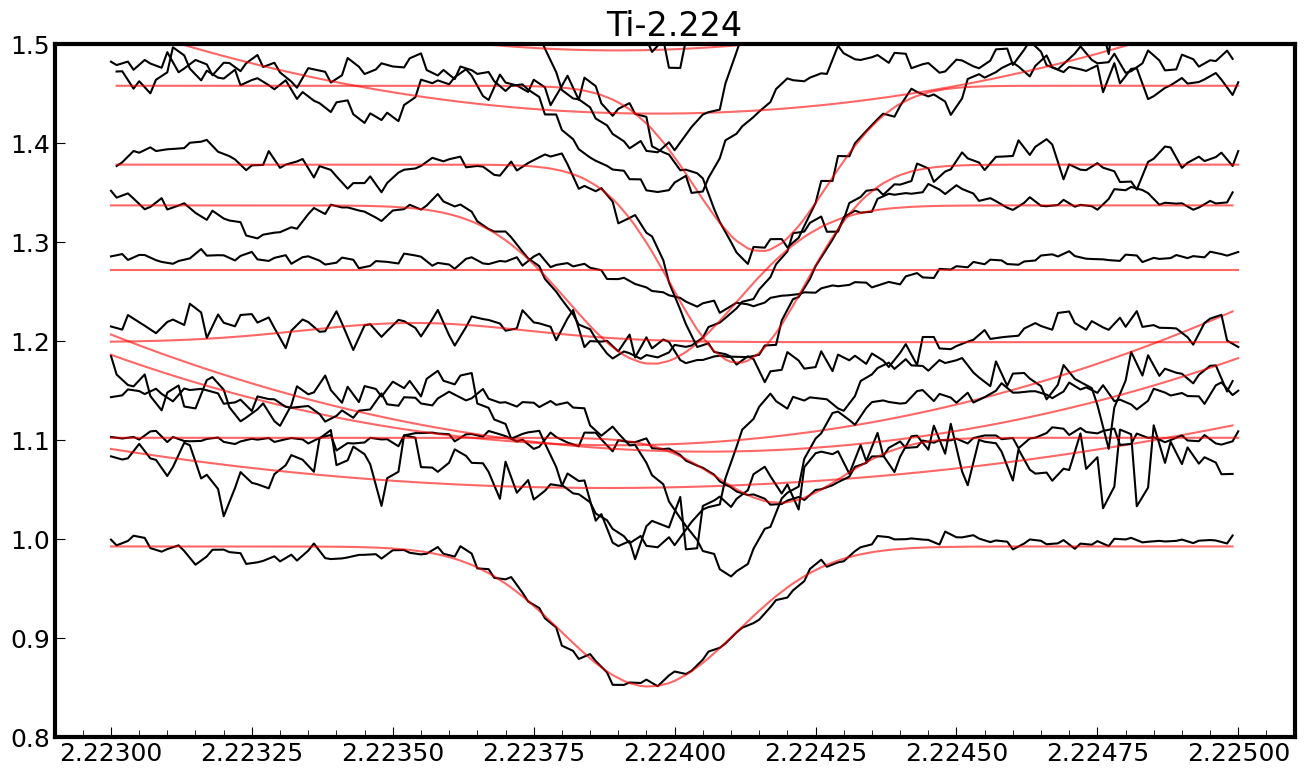

In [16]:
line_center = 2.224

fig, ax = plt.subplots(figsize=(16, 9))
flux_const = np.linspace(0,0.8,len(merged_standard_files))


for standard in range(len(merged_standard_files)):
    # Assuming ig.get_fitsdata returns wavelen, flux, snr
    wavelen, flux, snr = ig.get_fitsdata(merged_standard_files[standard])
    mask = (wavelen >= 2.223) & (wavelen < 2.225)
    norm_flux = ig.normalize_flux(flux)
    line_center = wavelen[mask][norm_flux[mask].argmin()]
    
    continuum, contlo_min, contlo_max, conthi_min, conthi_max = ig.local_continuum_fit(wavelen,flux,line_center)
    cont_sub = flux-continuum # the polyfit continuum-subtracted flux
    cont_norm = flux/continuum # polyfit continuum normalized flux
    
    meancont_sub = flux-np.mean(continuum) # the mean continuum-subtracted flux
    meancont_norm = flux/np.mean(continuum) # mean continuum normalized flux

    popt, pcov, best_model = ig.gauss_fit(wavelen,norm_flux,line_center,contlo_min,conthi_max)
    print(popt)

    # Plot spectrum and continuum fit
    ax.plot(wavelen[mask], norm_flux[mask]+flux_const[standard], '-', c='black')#, label='Spectrum {}'.format(standard))
    ax.plot(wavelen[mask], best_model[mask]+flux_const[standard], '-', c='red',alpha=0.6)
    # ax.plot(wavelen[mask], flux[mask] / cont_fit[mask], '-', mfc='black', mec='black', c='black')  # masked flux +flux_const[standard]
    ax.set_title('Ti-2.224') # make title
    # ax.set_xlim(start-15*ig.spec_res) # set xlim based on start and end wavelength values
    ax.set_ylim(0.8,1.5) #
plt.show()

In [17]:
# spec_step = 0.01
# test = np.arange(wavelen.min(), wavelen.max(), spec_step)  # arange to step through the spectrum in spec_step micron increments


# for start in test:
#     fig, ax = plt.subplots(figsize=(16, 9))
#     end = start + spec_step  # Determine
#     mask = (wavelen >= start) & (wavelen < end)
#     for standard in range(len(merged_standard_files)):
#         wavelen, flux, snr = ig.get_fitsdata(merged_standard_files[i])
#         # Fit continuum
#         spec = Spectrum1D(flux=flux*u.ct, spectral_axis=wavelen*u.um)
#         with warnings.catch_warnings():  # Ignore warnings
#             warnings.simplefilter('ignore')    
#             flux_fit = fit_generic_continuum(spec)
#         cont_fit = flux_fit(wavelen*u.um)

#         # ax.plot(wavelen, flux / cont_fit, '-', mfc='black', mec='black', c='black')  # global continuum subtracted flux
#     ax.plot(wavelen[mask], flux[mask] / cont_fit[mask], '-', mfc='black', mec='black', c='black')  # masked flux

#     ax.set_title(f'{start:.4f}-{end:.4f} ') # make title
#     ax.set_xlim(start,end) # set xlim based on start and end wavelength values

#     line_mask = (lines_table['Observed'] >= start) & (lines_table['Observed'] <= end) # bitwise conditional

#     label_added = {}  # Reset label_added dictionary for each plot

#     # for spectrum, color in zip([na1_mask, sc1_mask, si1_mask, fe1_mask, fe2_mask, al1_mask, mg1_mask, ca1_mask, h1_mask, ti1_mask],
#     #                             ['blue', 'orange', 'green', 'black', 'purple', 'brown', 'crimson', 'olive', 'cyan', 'red']):
#     #     for i in range(len(lines_table[line_mask & spectrum])):
#     #         spec_label = lines_table[line_mask & spectrum]['Spectrum'][0]  # Get the spectrum label
#     #         if spec_label not in label_added:  # Check if label has been added to the legend
#     #             plt.axvline(lines_table[line_mask & spectrum]['Observed'][0], ymin=0, ymax=0, ls='-', c=color, label=spec_label)
#     #             label_added[spec_label] = True  # Mark label as added
#     #         plt.axvline(lines_table[line_mask & spectrum]['Observed'][i], ymin=0.05 + 0.05 * list(label_added.keys()).index(spec_label), ymax=0.08 + 0.05 * list(label_added.keys()).index(spec_label), ls='-',lw=3, c=color)

#     plt.tight_layout()
#     plt.legend(markerscale=2,frameon=False)
#     # plt.savefig('./atomic_lines_figs/'+f'{start:.4f}-{end:.4f}.png') # save each section as .png
#     plt.show()

In [18]:
# spec_step = 0.005
# test = np.arange(wavelen.min(),wavelen.max(),spec_step) # arange to step through the spectrum in spec_step micron increments

# na1_mask = lines_table['Spectrum'] == 'Na I'
# sc1_mask = lines_table['Spectrum'] == 'Sc I' 
# si1_mask = lines_table['Spectrum'] == 'Si I'
# fe1_mask = lines_table['Spectrum'] == 'Fe I'
# fe2_mask = lines_table['Spectrum'] == 'Fe II'
# al1_mask = lines_table['Spectrum'] == 'Al I'
# mg1_mask = lines_table['Spectrum'] == 'Mg I'
# ca1_mask = lines_table['Spectrum'] == 'Ca I'
# h1_mask = lines_table['Spectrum'] == 'H I'
# ti1_mask = lines_table['Spectrum'] == 'Ti I'

# for start in test:
#     fig, ax = plt.subplots(figsize=(16,9))
#     end = start+spec_step # Determine 
#     mask = (wavelen >= start) & (wavelen < end)
#     # ax.plot(wavelen[mask],flux[mask],'-',mfc='black',mec='black',c='black') # Raw flux
#     # ax.plot(wavelen[mask],norm_flux[mask],'-',mfc='black',mec='black',c='black') # Median Normalized flux

#     ax.plot(wavelen[mask],flux[mask]/cont_fit[mask],'-',mfc='black',mec='black',c='black') # global continuum subtracted
#     ax.set_title(f'{start:.4f}-{end:.4f} ')

#     line_mask = (lines_table['Observed'] >= start) & (lines_table['Observed'] <= end)


    
#     for i in range(len(lines_table[line_mask & na1_mask])):
#         plt.text(x=lines_table[line_mask & na1_mask]['Observed'][0],y=0.8,s='Na I',size=12)
#         plt.axvline(lines_table[line_mask & na1_mask]['Observed'][0],ymin=0,ymax=0,ls='-',c='blue',label='Na I')
#         plt.axvline(lines_table[line_mask & na1_mask]['Observed'][i],ymin=0.05,ymax=0.08,ls='-',c='blue')
    

#     for i in range(len(lines_table[line_mask & sc1_mask])):
#         plt.axvline(lines_table[line_mask & sc1_mask]['Observed'][i],ymin=0.1,ymax=0.13,ls='-',c='orange')
#         plt.axvline(lines_table[line_mask & sc1_mask]['Observed'][0],ymin=0,ymax=0,ls='-',c='orange',label='Sc I')
        
#     for i in range(len(lines_table[line_mask & si1_mask])):
#         plt.axvline(lines_table[line_mask & si1_mask]['Observed'][0],ymin=0,ymax=0,ls='-',c='green',label='Si I')
#         plt.axvline(lines_table[line_mask & si1_mask]['Observed'][i],ymin=0.15,ymax=0.18,ls='-',c='green')

#     for i in range(len(lines_table[line_mask & fe1_mask])):
#         plt.axvline(lines_table[line_mask & fe1_mask]['Observed'][0],ymin=0,ymax=0,ls='-',c='black',label='Fe I')
#         plt.axvline(lines_table[line_mask & fe1_mask]['Observed'][i],ymin=0.2,ymax=0.23,ls='-',c='black')

#     for i in range(len(lines_table[line_mask & fe2_mask])):
#         plt.axvline(lines_table[line_mask & fe2_mask]['Observed'][i],ymin=0.25,ymax=0.28,ls='-',c='purple')

#     for i in range(len(lines_table[line_mask & al1_mask])):
#         plt.axvline(lines_table[line_mask & al1_mask]['Observed'][i],ymin=0.3,ymax=0.33,ls='-',c='brown')

#     for i in range(len(lines_table[line_mask & mg1_mask])):
#         plt.axvline(lines_table[line_mask & mg1_mask]['Observed'][i],ymin=0.35,ymax=0.38,ls='-',c='crimson')

#     for i in range(len(lines_table[line_mask & ca1_mask])):
#         plt.axvline(lines_table[line_mask & ca1_mask]['Observed'][i],ymin=0.4,ymax=0.43,ls='-',c='olive')

#     for i in range(len(lines_table[line_mask & h1_mask])):
#         plt.axvline(lines_table[line_mask & h1_mask]['Observed'][i],ymin=0.45,ymax=0.48,ls='-',c='cyan')

#     for i in range(len(lines_table[line_mask & ti1_mask])):
#         plt.axvline(lines_table[line_mask & ti1_mask]['Observed'][i],ymin=0.5,ymax=0.53,ls='-',c='red')
    
#     plt.tight_layout()
#     plt.legend(frameon=False)
#     plt.show()

In [19]:
na_reg_min = 2.2040
na_reg_max = 2.2120

na_region = Nist.query(na_reg_min*u.um,na_reg_max*u.um, linename='Na I, Sc I,Si I, Fe I, Fe II, Mg I, Al I',
                       energy_level_unit='eV',output_order='wavelength', wavelength_type='vacuum')
na_region_cut = (na_region['Observed'] > na_reg_min) & (na_region['Observed'] < na_reg_max)

na_reg_na = na_region[(na_region['Spectrum'] == 'Na I') & (na_region_cut)]
na_reg_sc1 = na_region[(na_region['Spectrum'] == 'Sc I')& (na_region_cut)]
na_reg_si1 = na_region[(na_region['Spectrum'] == 'Si I') & (na_region_cut)]
na_reg_fe1 = na_region[(na_region['Spectrum'] == 'Fe I') & (na_region_cut)]

na_reg_mg1 = na_region[(na_region['Spectrum'] == 'Mg I') & (na_region_cut)] # none?
na_reg_al1 = na_region[(na_region['Spectrum'] == 'Al I') & (na_region_cut)] # none?

ti_reg_min = 2.2000
ti_reg_max = 2.2400

ti_region = Nist.query(minwav=ti_reg_min*u.um,maxwav=ti_reg_max*u.um, linename='Ti I, Fe I, Na I, Sc I, Si I ')
ti_region_cut = (ti_region['Observed'] > ti_reg_min) & (ti_region['Observed'] < ti_reg_max)

ti_reg_ti = ti_region[(ti_region['Spectrum'] == 'Ti I') & (ti_region_cut)]
ti_reg_fe1 = ti_region[(ti_region['Spectrum'] == 'Fe I') & (ti_region_cut)]

ti_reg_na1 = ti_region[(ti_region['Spectrum'] == 'Na I') & (ti_region_cut)]
ti_reg_sc1 = ti_region[(ti_region['Spectrum'] == 'Sc I') & (ti_region_cut)]
ti_reg_si1 = ti_region[(ti_region['Spectrum'] == 'Si I') & (ti_region_cut)]

ca_reg_min = 2.2600
ca_reg_max = 2.2670

ca_region = Nist.query(minwav=ti_reg_min*u.um,maxwav=ti_reg_max*u.um, linename='Ca I, Fe I')
ca_region_cut = (ca_region['Observed'] > ca_reg_min) & (ca_region['Observed'] < ca_reg_max)

ca_reg_ca1 = ca_region[(ca_region['Spectrum'] == 'Ca I') & (ca_region_cut)]
ca_reg_fe1 = ca_region[(ca_region['Spectrum'] == 'Fe I') & (ca_region_cut)]

CO_reg_min = 2.2200
CO_reg_max = 2.2350

        Use "format" instead. [astroquery.nist.core]


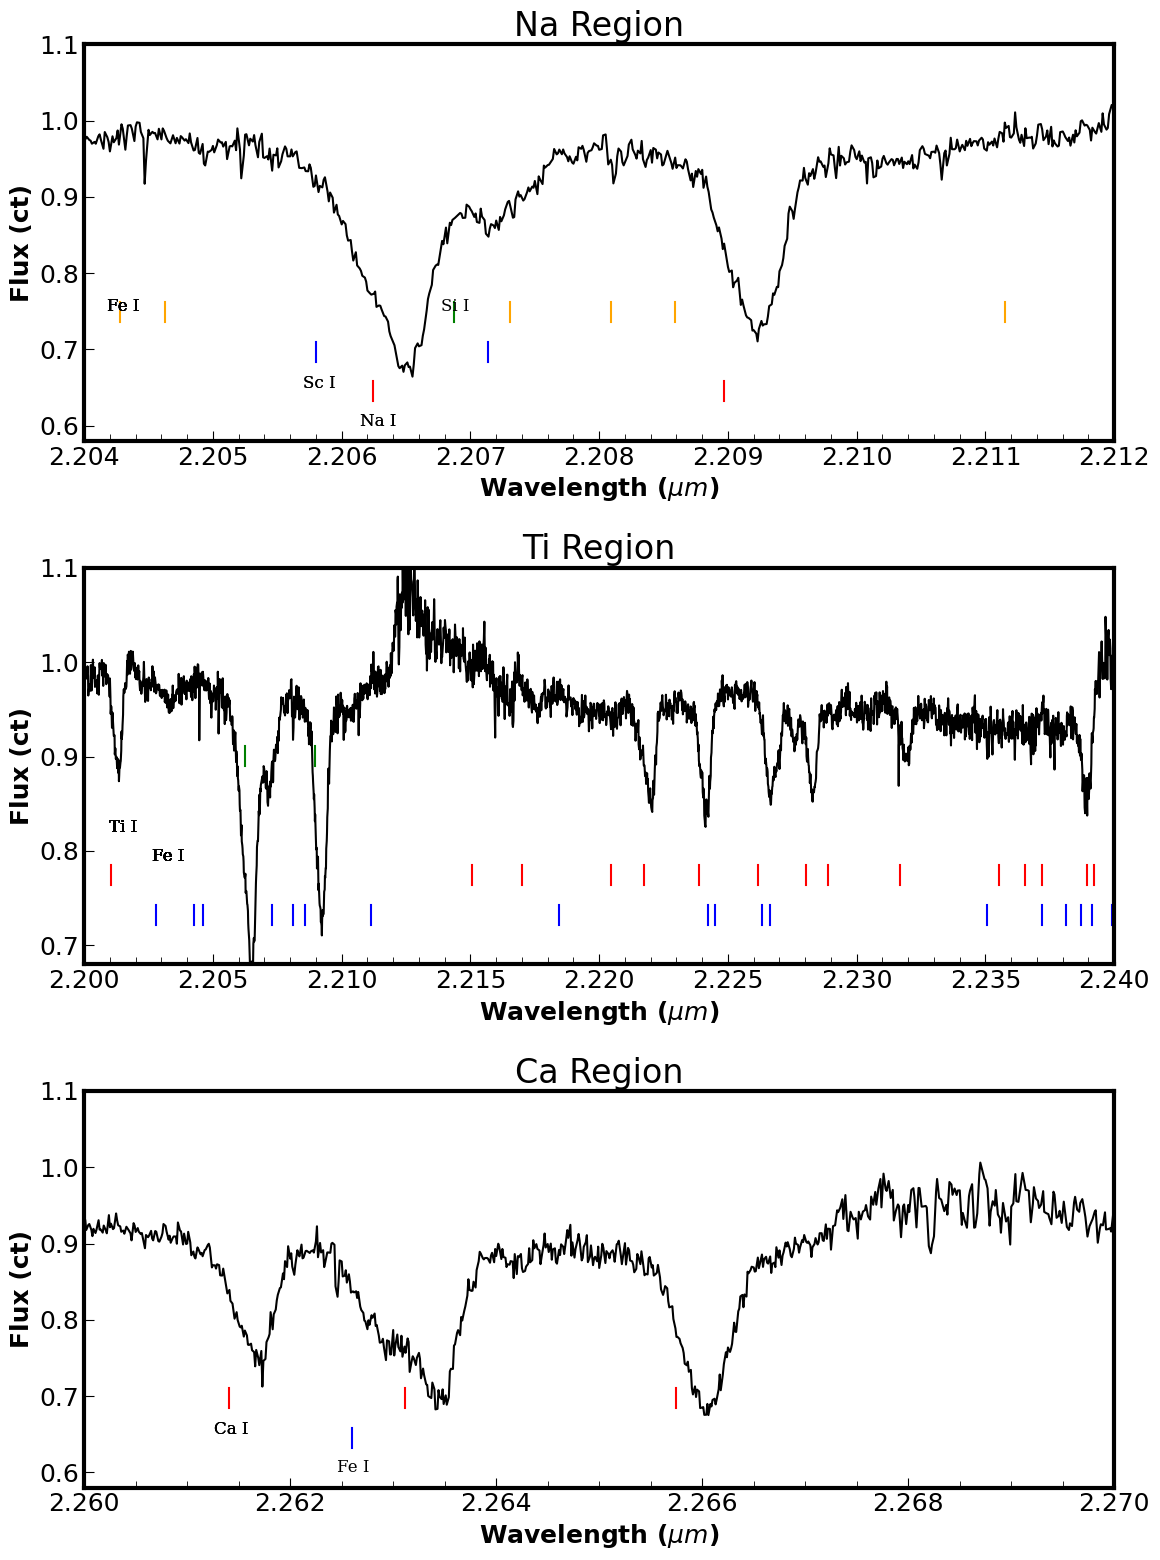

In [20]:
norm_flux = ig.normalize_flux(flux)
flux_max = 1.1

fig, ax = plt.subplots(3,1,figsize=(12,16))

# plt.plot(wavelen,flux,'.',mec='black')
ax[0].plot(wavelen,norm_flux,'-',mfc='black',mec='black',c='black')


for i in range(len(na_reg_na)):
    ax[0].axvline(na_reg_na['Observed'][i],ymin=0.1,ymax=0.15,ls='-',c='red',label='Na I Observed')
    ax[0].text(na_reg_na['Observed'][0]-0.0001,0.6,'Na I',fontsize=12,fontfamily='serif')
    # plt.axvline(na_reg_na['Ritz'][i],ls=':',c='pink',label = 'Na I Ritz')

for j in range(len(na_reg_sc1)):
    ax[0].axvline(na_reg_sc1['Observed'][j],ymin=0.2,ymax=0.25,ls='-',c='blue',label = 'Sc I Observed')
    ax[0].text(na_reg_sc1['Observed'][0]-0.0001,0.65,'Sc I',fontsize=12,fontfamily='serif')
    # plt.axvline(na_reg_sc1['Ritz'][j],ls=':',c='navy',label = 'Sc I Ritz')

for k in range(len(na_reg_si1)):
    ax[0].axvline(na_reg_si1['Observed'][k],ymin=0.3,ymax=0.35,ls='-',c='green',label = 'Si I Observed')
    ax[0].text(na_reg_si1['Observed'][0]-0.0001,0.75,'Si I',fontsize=12,fontfamily='serif')
    # plt.axvline(na_reg_si1['Ritz'][k],ls=':',c='forestgreen',label = 'Si I Ritz')

for ii in range(len(na_reg_fe1)):
    ax[0].axvline(na_reg_fe1['Observed'][ii],ymin=0.3,ymax=0.35,ls='-',c='orange',label = 'Fe I Observed')
    ax[0].text(na_reg_fe1['Observed'][0]-0.0001,0.75,'Fe I',fontsize=12,fontfamily='serif')
    # plt.axvline(na_reg_si1['Ritz'][k],ls=':',c='forestgreen',label = 'Si I Ritz')

ax[0].set_xlim(na_reg_min,na_reg_max)
ax[0].set_ylim(0.58,flux_max)

ax[0].set_xlabel('Wavelength ({})'.format('$\mu m$')) 
ax[0].set_ylabel('Flux ({})'.format("ct"))
ax[0].set_title('Na Region')

######

ax[1].plot(wavelen,norm_flux,'-',mfc='black',mec='black',c='black')

for i in range(len(ti_reg_ti)):
    ax[1].axvline(ti_reg_ti['Observed'][i],ymin=0.2,ymax=0.25,ls='-',c='red',label='Ti I Observed')
    ax[1].text(ti_reg_ti['Observed'][0]-0.0001,0.82,'Ti I',fontsize=12,fontfamily='serif')
    # plt.axvline(na_reg_na['Ritz'][i],ls=':',c='pink',label = 'Ti I Ritz')

for j in range(len(ti_reg_fe1)):
    ax[1].axvline(ti_reg_fe1['Observed'][j],ymin=0.1,ymax=0.15,ls='-',c='blue',label = 'Fe I Observed')
    ax[1].text(ti_reg_fe1['Observed'][0]-0.00015,0.789,'Fe I',fontsize=12,fontfamily='serif')
    # ax[1].axvline(ti_reg_fe1['Ritz'][j],ls=':',c='navy',label = 'Fe I Ritz')

for i in range(len(ti_reg_na1)):
    ax[1].axvline(ti_reg_na1['Observed'][i],ymin=0.5,ymax=0.55,ls='-',c='green',label='Na I Observed')
    # ax[1].text(ti_reg_ti['Observed'][0]-0.0001,0.82,'Na I',fontsize=12,fontfamily='serif')

ax[1].set_xlim(ti_reg_min,ti_reg_max)
ax[1].set_ylim(0.68,flux_max)

ax[1].set_xlabel('Wavelength ({})'.format('$\mu m$')) 
ax[1].set_ylabel('Flux ({})'.format("ct")) 
ax[1].set_title('Ti Region')

#######

ax[2].plot(wavelen,norm_flux,'-',mfc='black',mec='black',c='black')

for i in range(len(ca_reg_ca1)):
    ax[2].axvline(ca_reg_ca1['Observed'][i],ymin=0.2,ymax=0.25,ls='-',c='red',label='Ca I Observed')
    ax[2].text(ca_reg_ca1['Observed'][0]-0.00015,0.65,'Ca I',fontsize=12,fontfamily='serif')
    # plt.axvline(na_reg_na['Ritz'][i],ls=':',c='pink',label = 'Ti I Ritz')

for j in range(len(ca_reg_fe1)):
    ax[2].axvline(ca_reg_fe1['Observed'][j],ymin=0.1,ymax=0.15,ls='-',c='blue',label = 'Fe I Observed')
    ax[2].text(ca_reg_fe1['Observed'][0]-0.00015,0.6,'Fe I',fontsize=12,fontfamily='serif')
    # ax[1].axvline(ti_reg_fe1['Ritz'][j],ls=':',c='navy',label = 'Fe I Ritz')


ax[2].set_xlim(ca_reg_min,2.27)
ax[2].set_ylim(0.58,flux_max)

ax[2].set_xlabel('Wavelength ({})'.format('$\mu m$')) 
ax[2].set_ylabel('Flux ({})'.format("ct"))
ax[2].set_title('Ca Region')

plt.tight_layout()
plt.show()

In [21]:
please = (wavelen > 2.206) & (wavelen < 2.207)
(norm_flux[please].argmin())
wavelen[please][25]

2.2063400745391846

In [22]:
wavelen[please][25] - na_reg_na['Observed'][0]

9.80745391845339e-05

# Gaussian Fitting
---

In [23]:
yso_line_dict = {
 'H2 v=2-1 S(5)': 1.944,
 'HeI 16.8': 1.94429,
 'HI 8-4 Brd': 1.9451,
 'H2 v=1-0 S(3)': 1.957,
 'H2 v=3-2 S(7)': 1.969,
 '[Mn II]': 2.00229,
 'H2 v=2-1 S(4)': 2.004,
 '[Ti I]': 2.008516,
 'H2 v=3-2 S(6)': 2.013,
 'H2 v=1-0 S(2)': 2.033,
 'HeI 15-8': 2.03788,
 'HeI 1P-1': 2.0567,
 'He I 2.05': 2.05869,
 'H2 v=3-2 S(5)': 2.065,
 'H2 v=2-1 S(3)': 2.073,
 'HeI 3S-3': 2.1126,
 'H2 v=1-0 S(1)': 2.121,
 'H2 v=3-2 S(4)': 2.128,
 'H2 v=2-1 S(2)': 2.154,
 'HeI 14-8': 2.16523,
 'HI 7-4 Brg': 2.1661,
 'HeI 10-7': 2.18911,
 'H2 v=3-2 S(3)': 2.201,
 'H2 v=4-3 S(5)': 2.201,
 '[Fe III]': 2.2184,
 'H2 v=1-0 S(0)': 2.223,
 'H2 v=2-1 S(1)': 2.247,
 'H2 v=5-4 S(7)': 2.251,
 'H2 v=4-3 S(4)': 2.266,
 '[Fe II]': 2.28573,
 'H2 v=3-2 S(2)': 2.287,
 'CO 2-0': 2.2935,
 'CO 3-1': 2.3227,
 'H2 v=4-3 S(3)': 2.344,
 'HI 30-5': 2.34455,
 'HeI 13-8': 2.34703,
 'HI 29-5': 2.34926,
 'CO 4-2': 2.3525,
 'HI 28-5': 2.3545,
 'H2 v=2-1 S(0)': 2.355,
 'H2 v=5-4 S(5)': 2.355,
 'HI 27-5': 2.36037,
 'HI 26-5': 2.36696,
 'HI 25-5': 2.3744,
 'HeI 19-9': 2.37945,
 'HI 24-5': 2.38284,
 'CO 5-3': 2.3829,
 'H2 v=3-2 S(1)': 2.386,
 'HI 23-5': 2.39249,
 'HI 22-5': 2.40357,
 'H2 v=1-0 Q(1)': 2.406,
 'H2 v=1-0 Q(2)': 2.413,
 'CO 6-4': 2.4142,
 'HI 21-5': 2.4164,
 'H2 v=1-0 Q(3)': 2.423,
 'HI 20-5': 2.43138,
 'H2 v=1-0 Q(4)': 2.437,
 'CO 7-5': 2.4461,
 'HI 19-5': 2.44902,
 'H2 v=1-0 Q(5)': 2.454,
 'HeI 18-9': 2.46074,
 '[Fe II]??': 2.467565,
 'HI 18-5': 2.47001,
 'H2 v=1-0 Q(6)': 2.475,
 'CO 8-6': 2.4787,
 'HI 17-5': 2.49527,
}

yso_line_dict = dict(sorted(yso_line_dict.items(), key=lambda item: item[1]))

# Strings of the lines
ysolines_str = list(yso_line_dict.keys())

# Wavelength values for each line
ysolines_wav = np.array(list(yso_line_dict.values()))

ysolines_wav = ysolines_wav[(ysolines_wav > wavelen.min()) & (ysolines_wav < wavelen.max())]

# NIR Lines in micron
nir_dict = {
    "Fe-2.084"  :   2.084088,
    "Si-2.092"	:   2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.22397,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573":	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297
}
# The CO Overtones will be an interesting challenge I'm sure
    # "CO(2-0)-2.29353" :	2.29353,
    # "CO(2-0)-2.32265"	:	2.32265,
    # "CO(2-0)-2.34327" :	2.34327,
    # "CO(2-0)-2.34531" :	2.34531,
    # "CO(2-0)-2.3495" 	:	2.3495,
    # "CO(2-0)-2.35167"	:	2.35167,
    # "CO(2-0)-2.35246" :	2.35246,
    # "CO(2-0)-2.38295" :	2.38295,
    # }

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = np.array(list(nir_dict.values()))

# Just a list of the elemental shorthand symbols
labels = [string.split('-')[0] for string in lines_str]

In [24]:
range(0,2)

range(0, 2)

In [25]:
# line_center = lines_wav[16]
# for i in range(0,17):
#     wavelen, flux, snr = ig.get_fitsdata(merged_standard_files[i])
#     norm_flux = ig.normalize_flux(flux)

#     continuum, contlo_min, contlo_max, conthi_min, conthi_max = ig.local_continuum_fit(wavelen,flux,line_center)

#     cont_sub = flux-continuum # the polyfit continuum-subtracted flux
#     cont_norm = flux/continuum # polyfit continuum normalized flux

#     meancont_sub = flux-np.mean(continuum) # the mean continuum-subtracted flux
#     meancont_norm = flux/np.mean(continuum) # mean continuum normalized flux

#     popt, pcov, best_model = ig.gauss_fit(wavelen,cont_norm,line_center,contlo_min,conthi_max)

#     fig = plt.subplots(figsize=(16,9))

#     plt.axhline(1,color='orange',lw=1,ls='-')
#     plt.axhline(0,color='black',lw=3,ls=':')

#     plt.plot(wavelen,1-norm_flux,ls='-.', color='black', label='Median Normalized')
#     plt.plot(wavelen,1-cont_norm, color='orchid',label='Continuum Normalized')
#     # plt.plot(wavelen,1-meancont_norm,ls=':', color='darkmagenta',label='Mean Continuum Normalized')

#     plt.plot(wavelen,1-best_model,ls='-', color='red',label='Gaussian Fit')
#     # plt.plot(wavelen,1-best_model2,ls=':', color='red',label='Gaussian Fit')

#     # Continuum Estimation region
#     plt.axvspan(wavelen[contlo_min],wavelen[contlo_max], color='black', alpha=0.2,label='Continuum window')
#     plt.axvspan(wavelen[conthi_min],wavelen[conthi_max], color='black', alpha=0.2)


#     for i in range(len(lines_wav)):
#         plt.axvline(lines_wav[i],.1,.15,ls='-',lw=3,c='crimson')
#         # plt.axvline(ysolines_wav[i],.1,.15,ls='-',lw=3,c='crimson')

#     plt.xlim(line_center-150*spec_res,line_center+150*spec_res)
#     # 0.05
#     # plt.ylim(-.5,.25)
#     plt.ylim((1-norm_flux[contlo_min:conthi_max]).min()-.09,(1-norm_flux[contlo_min:conthi_max]).max()+.09)

#     plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
#     plt.ylabel('Flux ({})'.format("ct"))

#     plt.title(lines_str[16])

#     plt.legend()
#     plt.show()

In [26]:
# initial guesses, need 4 inputs: Amplitude, center, std_dev, b (y offset)
init_params = (1-cont_norm[contlo_min:conthi_max]).max(), line_center, 1., 1.

popt1, pcov1 = curve_fit(f=gaussian_func,
                        xdata=wavelen[contlo_min:conthi_max],
                        ydata=cont_norm[contlo_min:conthi_max],
                        maxfev=50000)

best_model1 = gaussian_func(wavelen,*popt)

print("Best Fit Parameters:", popt1)

Best Fit Parameters: [-5.86337531e-05  2.22413229e+00  1.88514941e-04  9.96762464e-01]


In [27]:
popt2, pcov2, best_model2 = ig.gauss_fit(wavelen,cont_norm,line_center,contlo_min,conthi_max)
popt2

array([-5.86337531e-05,  2.22413229e+00,  1.88514941e-04,  9.96762464e-01])

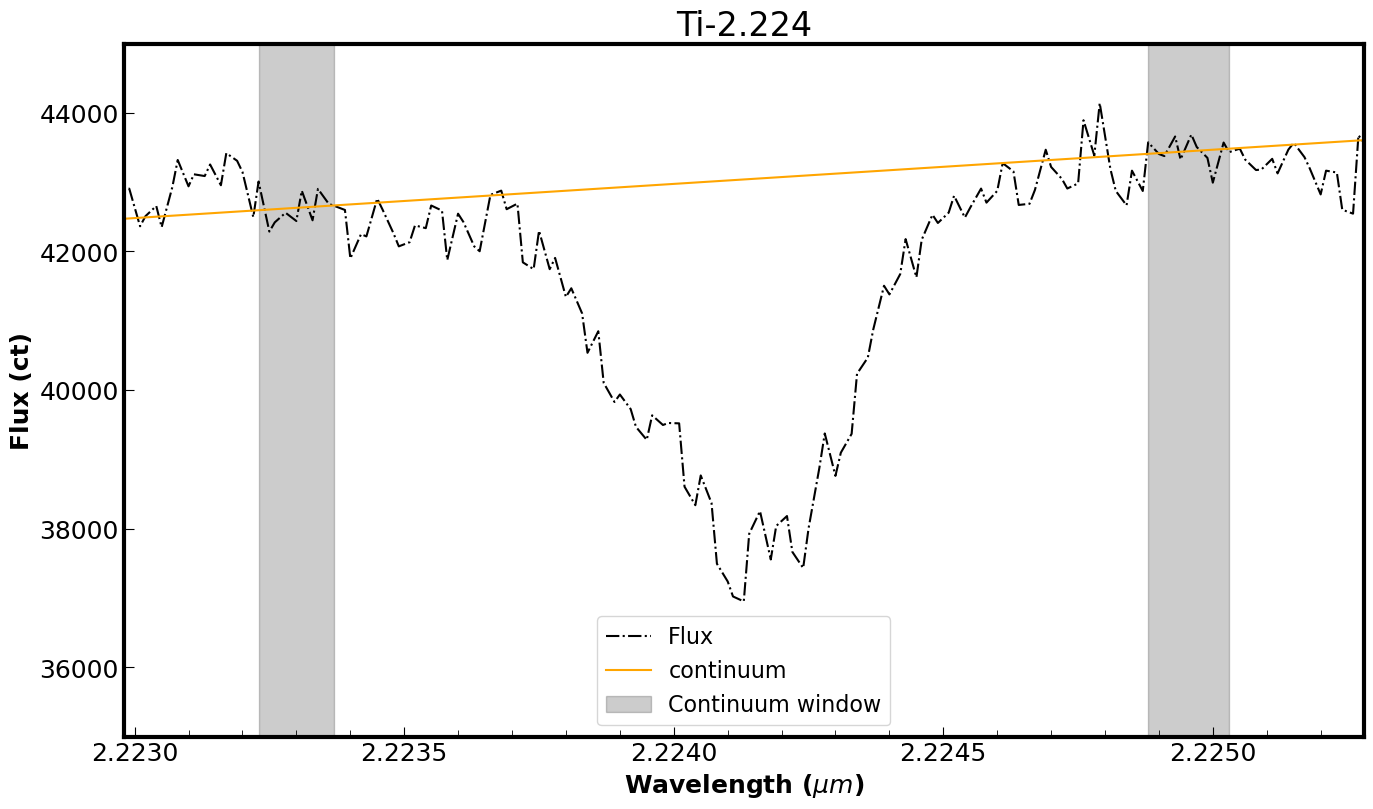

In [28]:
fig = plt.subplots(figsize=(16,9))

# plt.axhline(1,color='orange',lw=1,ls='-')
# plt.axhline(0,color='black',lw=3,ls=':')

plt.plot(wavelen,flux,ls='-.', color='black', label='Flux')
plt.plot(wavelen,continuum,ls='-', color='orange', label='continuum')

# Continuum Estimation region
plt.axvspan(wavelen[contlo_min],wavelen[contlo_max], color='black', alpha=0.2,label='Continuum window')
plt.axvspan(wavelen[conthi_min],wavelen[conthi_max], color='black', alpha=0.2)

plt.xlim(wavelen[contlo_min]-25*spec_res,wavelen[conthi_max]+25*spec_res)
plt.ylim(35e3,45e3)

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct"))

plt.title(lines_str[16])

plt.legend()
plt.show()

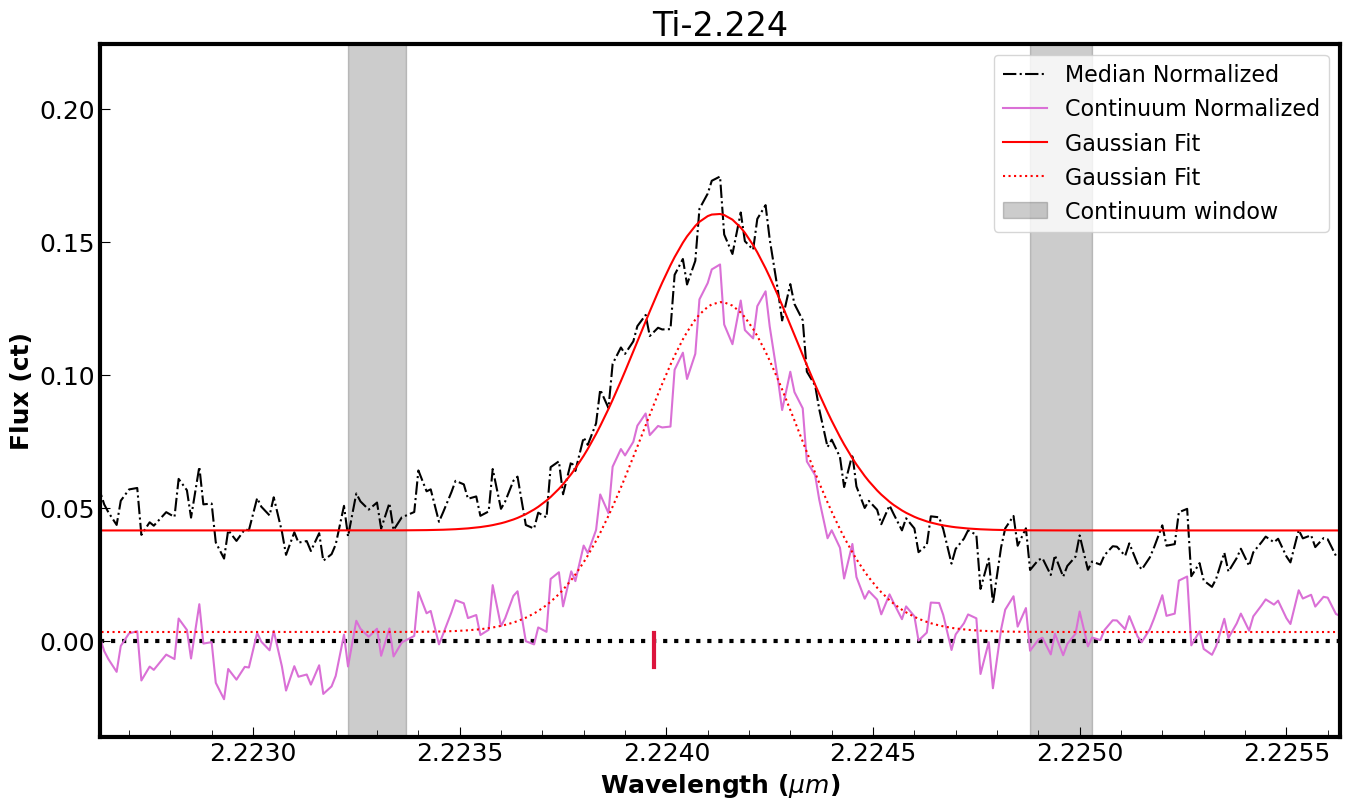

In [29]:
fig = plt.subplots(figsize=(16,9))

plt.axhline(1,color='orange',lw=1,ls='-')
plt.axhline(0,color='black',lw=3,ls=':')

plt.plot(wavelen,1-norm_flux,ls='-.', color='black', label='Median Normalized')
plt.plot(wavelen,1-cont_norm, color='orchid',label='Continuum Normalized')
# plt.plot(wavelen,1-meancont_norm,ls=':', color='darkmagenta',label='Mean Continuum Normalized')

plt.plot(wavelen,1-best_model1,ls='-', color='red',label='Gaussian Fit')
plt.plot(wavelen,1-best_model2,ls=':', color='red',label='Gaussian Fit')

# Continuum Estimation region
plt.axvspan(wavelen[contlo_min],wavelen[contlo_max], color='black', alpha=0.2,label='Continuum window')
plt.axvspan(wavelen[conthi_min],wavelen[conthi_max], color='black', alpha=0.2)


for i in range(len(lines_wav)):
    plt.axvline(lines_wav[i],.1,.15,ls='-',lw=3,c='crimson')
    # plt.axvline(ysolines_wav[i],.1,.15,ls='-',lw=3,c='crimson')

plt.xlim(line_center-150*spec_res,line_center+150*spec_res)
# 0.05
# plt.ylim(-.5,.25)
plt.ylim((1-norm_flux[contlo_min:conthi_max]).min()-.05,
         (1-norm_flux[contlo_min:conthi_max]).max()+.05)

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct"))

plt.title(lines_str[16])

plt.legend()
plt.show()

# Equivalent Width
---
$\begin{equation}
    W_\lambda = \int 1 - \frac{F_s}{F_c} d\lambda
\end{equation}$

In [30]:
# # Integrate the Gaussian to get equivalent  width
# ew1 = trapz(best_model,wavelen)
# print(lines_str[16] + f' Equivalent Width: {ew1:.8f}') # Units TBD

In [31]:
# # Integration to get equivalent  width
# ew2 = trapz(1-cont_norm,wavelen)
# print(lines_str[16] + f' Equivalent Width: {ew2:.8f}') # Units TBD